In [1]:
!pip install -Uq gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.6 MB/s eta 0:00:00


# Code

In [2]:
import tqdm
import math
import torch
import numpy as np
import pprint

import torch.distributions as dist

import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import math
from numbers import Number, Real

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

__all__ = ["CensoredNormal"]



class CensoredNormal(ExponentialFamily):
    """
    Creates a censored normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale` and :attr:`low`  and :attr:`high`

    Example::

        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> m = CensoredNormal(
          torch.tensor([0.0]), torch.tensor([1.0]),
          torch.tensor([-0.5]), torch.tensor([0.5])
          )
        >>> m.sample(sample_shape=(3,1))
        tensor([[0.5000],
            [0.5000],
            [0.1836]])
        tensor([ 0.1046])

    Args:
        loc (float or Tensor): mean of the base normal distribution (often referred to as mu) to which the censoring is applied
        scale (float or Tensor): standard deviation of the base normal distribution to which the censoring is applied
        low (float or Tensor): lower censoring boundary
        high (float or Tensor): upper censoring boundary
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "low": constraints.dependent(is_discrete=False, event_dim=0),
        "high": constraints.dependent(is_discrete=False, event_dim=0)}
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = pdf_high - pdf_low
        return self.loc * term1 - self.scale * term2

    @property
    def stddev(self):
        return self.variance.sqrt()

    @property
    def variance(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = x_high * pdf_high - x_low * pdf_low
        return  (self.scale ** 2) * (term1 - term2)


    def __init__(self, loc, scale, low, high, validate_args=None):
        self.loc, self.scale, self.low, self.high = broadcast_all(loc, scale, low, high)
        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(low, Number) and isinstance(high, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        support = constraints.interval(low, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.low = self.low.expand(batch_shape)
        new.high = self.high.expand(batch_shape)
        super(CensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    @constraints.dependent_property(is_discrete=False, event_dim=0)
    def support(self):
        return constraints.interval(self.low, self.high)


    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            samples = torch.normal(self.loc.expand(shape), self.scale.expand(shape))
            return samples.clamp(min=self.low, max=self.high)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        rsamples =  self.loc + eps * self.scale
        return rsamples.clamp(min=self.low, max=self.high)

    def pdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        probs = torch.exp(self.log_prob(value))
        lower_cdf_mass = self._normal_cdf(self.low)
        upper_cdf_mass = 1 - self._normal_cdf(self.high)
        probs = torch.where(value <= self.low, lower_cdf_mass, probs)
        probs = torch.where(value >= self.high, upper_cdf_mass, probs)
        return probs

    def log_prob(self, value, jitter=1e-12):
        """jitter: used to bounce off NormCDF from 0 before applying log """
        if self._validate_args:
            self._validate_sample(value)
        log_probs = self._normal_log_prob(value)
        lower_log_cdf_mass = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                Number) else (self._normal_cdf(self.low) + jitter).log()
        upper_log_cdf_mass = math.log(1 - self._normal_cdf(self.high) + jitter) if isinstance(1 - self._normal_cdf(self.high) + jitter,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + jitter).log()
        log_probs = torch.where(value <= self.low, lower_log_cdf_mass, log_probs)
        log_probs = torch.where(value >= self.high, upper_log_cdf_mass, log_probs)
        return log_probs

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        cdf_ = self._normal_cdf(value)
        cdf_ = torch.where(value < self.low, 0, cdf_)
        cdf_ = torch.where(value > self.high, 1, cdf_)
        return cdf_

    def icdf(self, value):
        result = self._normal_icdf(value)
        return result.clamp(min=self.low, max=self.high)

    def entropy(self, jitter=1e-12):
        x_low = (self.low - self.loc)/self.scale
        x_high = (self.high - self.loc)/self.scale

        logcdf_x_low = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                  Number) else (self._normal_cdf(self.low) + jitter).log()
        logcdf_x_high = math.log(self._normal_cdf_standardized(-x_high) + jitter) if isinstance(self._normal_cdf_standardized(x_high) + jitter,
                                                                                                      Number) else (self._normal_cdf_standardized(-x_high) + jitter).log()

        term1 = self._normal_entropy() * (self._normal_cdf(self.high)- self._normal_cdf(self.low))
        term2 = 0.5 * (x_high * torch.exp(self._normal_log_prob(self.high)) - x_low * torch.exp(self._normal_log_prob(self.low)))
        term3 = logcdf_x_low * self._normal_cdf(self.low)
        term4 = logcdf_x_high * (self._normal_cdf_standardized(-x_high))
        return term1 - term2 - term3 - term4


    def _normal_log_prob(self, value):
            # compute the variance
            var = self.scale**2
            log_scale = (
                math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
            )
            return (
                -((value - self.loc) ** 2) / (2 * var)
                - log_scale
                - math.log(math.sqrt(2 * math.pi))
            )

    def _normal_cdf(self, value):
        return 0.5 * (
            1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2))
        )

    def _normal_cdf_standardized(self, z):
        return 0.5 * (
            1 + torch.erf(z / math.sqrt(2))
        )

    def _normal_icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)


    def _normal_entropy(self):\
        # log(sqrt(2 pi e) * sigma) = 0.5 * log(2 pi e) + log(sigma) = 0.5 + 0.5 (log(2 pi)) + log(sigma)
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    @property
    def _normal_natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)

In [4]:
import math
import warnings
from copy import deepcopy
from typing import Any, Optional, Tuple, Union

import numpy as np
import torch
import torch.distributions as dist
from torch import Tensor
from gpytorch.likelihoods.likelihood import _Likelihood
from gpytorch.likelihoods.noise_models import HomoskedasticNoise


class CensoredGaussianLikelihood(_Likelihood):
    """Base class for Censored Gaussian Likelihoods."""
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.noise = HomoskedasticNoise()
        self.noise.initialize(noise=variance)
        self.low = low
        self.high = high

    @property
    def variance(self):
      return self.noise.noise

    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any):
        return CensoredNormal(function_samples, scale=self.variance.sqrt(), low=self.low, high=self.high)


class CensoredGaussianLikelihoodAnalytic(CensoredGaussianLikelihood):
    def __init__(self, variance=None, low=None, high=None, alpha=1., gamma=1., dzeta=1., jitter_=1e-16) -> None:
        super().__init__(variance, low, high)
        self.alpha = alpha
        self.gamma = gamma
        self.dzeta = dzeta
        self.jitter_ = jitter_

    def expected_log_prob(self, target: Tensor, input: dist.MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance # likelihood
        sigma = noise.sqrt()
        mean, variance = input.mean, input.variance # approximate posterior
        std = variance.sqrt()

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        res = ((target - mean).square() + variance) / noise + noise.log() + math.log(2 * math.pi)
        res = res.mul(-0.5)
        term3 = standard_normal.cdf(upper_censor(mean, std)) - standard_normal.cdf(lower_censor(mean, std))
        normal_part = res * term3  # log-likelihood, maximized

        # upper term
        x = 0.5 * (self.high - 2*target + mean) * std * noise.reciprocal()  # minimized
        upper_term_cdf = standard_normal.cdf(-upper_censor(target, sigma))
        ln_cdf = torch.clamp_min(upper_term_cdf, self.jitter_).log()
        upper_term_pdf = standard_normal.log_prob(upper_censor(mean, std)).exp()
        upper_censored_part = (ln_cdf + x) * upper_term_pdf  # minimized

        # lower term
        x = 0.5 * (self.low - 2*target + mean) * std * noise.reciprocal()  # maximized
        lower_term_cdf = standard_normal.cdf(lower_censor(target, sigma))
        ln_cdf = torch.clamp_min(lower_term_cdf, self.jitter_).log()
        lower_term_pdf = standard_normal.log_prob(lower_censor(mean, std)).exp()
        lower_censored_part = (ln_cdf - x) * lower_term_pdf  # minimized

        res = self.alpha * normal_part - self.gamma * upper_censored_part - self.dzeta * lower_censored_part
        return res

In [5]:
def rgetattr(o, k_list):
  for k in k_list:
    o = getattr(o,k)
  return o

def print_module(module):
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      print(f'{name:35} {tuple(param.shape)}\n{param.numpy().round(10)}')

def get_module(module):
  ret = {}
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      ret[name] = param.numpy()
  return ret

# Create Data Pool - Synthetic 1D

In [6]:
MAX_VALUE = 0.0

def noise_free_target(x):
    y = (x-2)*10
    return y * torch.sin(y) / 2

def oracle(x):
    return torch.clamp_max(noise_free_target(x) + torch.randn(x.shape) , MAX_VALUE)

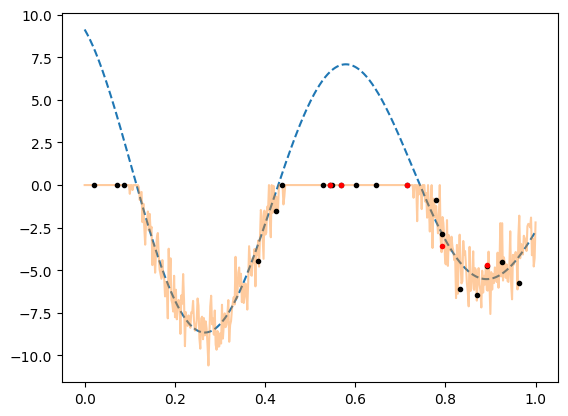

In [16]:
# initiate the data pool
N_pool = 20
N_init = 5

# get labels for the base learner
np.random.seed(0)
x_init = torch.FloatTensor(np.random.rand(N_pool))
idx_init = torch.randint(0, x_init.size(0), size=(N_init,)) # sample initial dataset
x = x_init[idx_init]

torch.sort(x_init)
torch.sort(x)
y_init= oracle(x_init)
y = oracle(x)

# test set for ploting and evaluation
domain = torch.linspace(0, 1, 500)
y_test = noise_free_target(domain)
y_test_censored = oracle(domain)

plt.plot(domain, y_test, '--');
plt.plot(domain, y_test_censored, '-', alpha=0.4);
plt.plot(x_init, y_init, 'k.')
plt.plot(x, y, 'r.')


# construct the unlabeled pool
mask = torch.ones(x_init.size())
mask[idx_init] = 0
x_pool_init = x_init[mask.bool()]
x_pool = x_pool_init

# Base Learner

In [17]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        # defines approximation
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [24]:
model = GPModel(inducing_points=x[:,None])
# select likelihood:
likelihood = CensoredGaussianLikelihood(low=-100., high=MAX_VALUE)
#likelihood = CensoredGaussianLikelihoodAnalytic(low=-100., high=MAX_VALUE)

loss = gpytorch.mlls.VariationalELBO(likelihood, model, beta=1., combine_terms=False, num_data=y.size(0))

optimizer = torch.optim.Adam([
      {'params': model.parameters()},
      {'params': likelihood.parameters()},
  ], lr=0.001)


model = model.to(device)
likelihood = likelihood.to(device)

In [31]:
def evaluate_learner(model, likelihood, x_test, y_test):
  model.eval()
  likelihood.eval()
  f_preds = model(x_test.to(device))

  return {
      'mae': gpytorch.metrics.mean_absolute_error(f_preds, y_test.to(device)).numpy(force=True),
      'posterior_log_prob': f_preds.log_prob(y_test.to(device)).mean().numpy(force=True),
      'npld_posterior': gpytorch.metrics.negative_log_predictive_density(f_preds, y_test.to(device)).mean().numpy(force=True),
      'npld_predictive_posterior': gpytorch.metrics.negative_log_predictive_density(likelihood(f_preds), y_test_censored.to(device)).mean().numpy(force=True)
    }

def train_learner(x, y, model_, likelihood_, loss_, optimizer_, num_epochs_, print_idx_, monitor_metrics=True):
  num_epochs = num_epochs_
  model = model_
  likelihood = likelihood_
  optimizer = optimizer_
  mll = loss_

  pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True)
  params_log = dict()
  metrics = dict()

  model.train()
  likelihood.train()
  for iter in pbar:
      optimizer.zero_grad()
      y_pred = model(x.to(device))
      log_likelihood, kl_divergence, log_prior  = mll(y_pred, y.to(device))
      loss = -(log_likelihood - kl_divergence + log_prior)
      loss.backward()
      optimizer.step()
      params_log[iter] = {
          'loss': loss.item(),
          'log_likelihood': log_likelihood.item(),
          'kl_divergence': kl_divergence.item(),
          'log_prior': log_prior.item(),
          'outscale': model.covar_module.outputscale.item(),
          'mean_module': model.mean_module.constant.item(),
          'noise': likelihood.noise.noise.item()
          }

      if iter%1000==0:
        for key, val in params_log[iter].items():
          print(key, val)

        if monitor_metrics==True:
          metrics[iter] = evaluate_learner(model, likelihood, domain[:,None], y_test)
          model.train()

  if monitor_metrics == True:
    df_params = pd.DataFrame(params_log).T
    df_metrics = pd.DataFrame(metrics).T
    df_logs = pd.concat([df_params, df_metrics], axis=1)
  else:
    df_logs = pd.DataFrame(params_log).T

  return {
      'model': model,
      'likelihood': likelihood,
      'logs': df_logs
  }

trainig_results = train_learner(x[:,None], oracle(x), model, likelihood, loss, optimizer, 100, 10)

 13%|█▎        | 13/100 [00:00<00:01, 64.84it/s]

loss 6.364511013031006
log_likelihood -6.364500999450684
kl_divergence 1.0061264219984878e-05
log_prior 0.0
outscale 0.6916621327400208
mean_module -0.0030012393835932016
noise 1.001896858215332


100%|██████████| 100/100 [00:01<00:00, 72.74it/s]


In [32]:
evaluate_learner(trainig_results['model'], trainig_results['likelihood'], domain[:, None], y_test)

{'mae': array(4.716313, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01715362, dtype=float32)}

In [ ]:
# model.covar_module.base_kernel.initialize(lengthscale=0.1);
# model.covar_module.initialize(outputscale=5);
# model.mean_module.initialize(constant=0)
# likelihood.noise.initialize(noise=1/10);

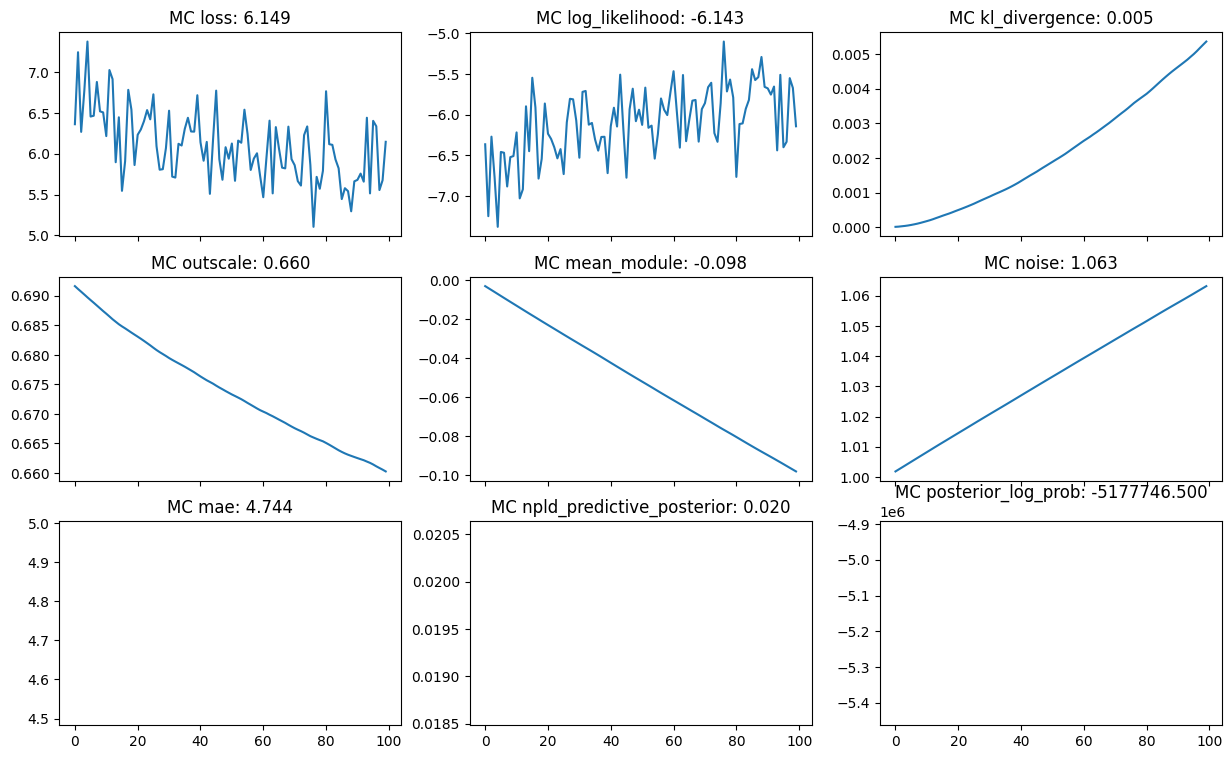

In [33]:
def plot_metrics(df_, monitor_metrics=True):
  cols = df_.columns.to_list()
  cols.remove('log_prior')

  if monitor_metrics==True:
    cols.remove('npld_posterior')
    fig, ax = plt.subplots(3, 3, figsize=(15,9), sharex=True)
  else:
    fig, ax = plt.subplots(2, 3, figsize=(15,9), sharex=True)

  for col_, ax_ in zip(cols, ax.flatten()):
    df_[col_].dropna().astype('float').plot(title='MC %s: %.3f'%(col_,  df_[col_].dropna().astype('float').tail(1).values[0]), ax=ax_)

  plt.show()

plot_metrics(trainig_results['logs'])

In [35]:
# get posterior and predictiv
model.eval()
likelihood.eval()

f_preds = model(domain[:,None].to(device))
y_preds = likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


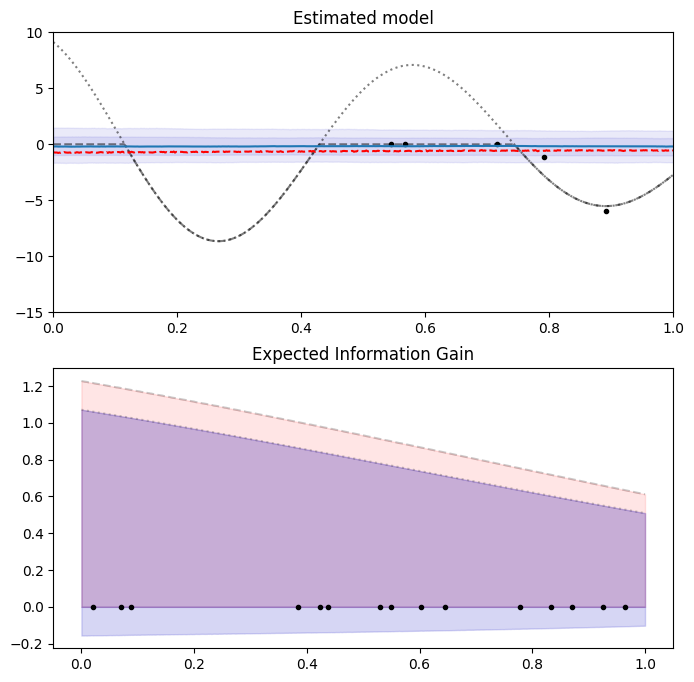

In [58]:
def plot_result(model, likelihood, x_pool=x_pool_init):
    model.eval()
    likelihood.eval()

    posterior = model(domain[:,None].to(device))
    predictive_posterior = likelihood(posterior)

    pred_samples = posterior.sample_n(1000).to(device)
    entropy = likelihood(domain[:,None].to(device)).entropy().reshape(-1)
    posterior_entropy = pred_samples * entropy

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
      pred_median = np.median(pred_samples.numpy(force=True), axis=0)
      pred_quantiles = np.quantile(pred_samples.numpy(force=True), [0.025, 0.15, 0.85, 0.975], axis=0)

      fig, ax = plt.subplots(2, 1, figsize = (8, 8))
      ax[0].plot(x, oracle(x), 'k.');
      ax[0].plot(domain, noise_free_target(domain), 'k:', alpha=0.5)
      ax[0].plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);
      ax[0].plot(domain, pred_median)

      ax[0].fill_between(domain, pred_quantiles[0], pred_quantiles[-1], alpha=0.1, color='#33c');
      ax[0].fill_between(domain, pred_quantiles[1], pred_quantiles[-2], alpha=0.1, color='#33c');
      ax[0].plot(domain, predictive_posterior.sample_n(n=100).mean([0,1]).numpy(force=True), 'r--')
      ax[0].set_xlim(0, 1);
      ax[0].set_ylim(-15, 10);
      ax[0].set_title("Estimated model")

      ax[1].set_title("Expected Information Gain")
      ax[1].fill_between(domain, entropy.to('cpu'), alpha=0.3, color='#33c')
      ax[1].plot(domain, entropy.to('cpu'), 'k:', alpha=0.2)

      ax[1].fill_between(domain, torch.zeros_like(domain), posterior_entropy.mean(0).to('cpu'), color='#33c', alpha=0.2)
      ax[1].fill_between(domain, entropy.to('cpu')-posterior_entropy.mean(0).to('cpu'), alpha=0.1, color='red')
      ax[1].plot(domain, entropy.to('cpu')-posterior_entropy.mean(0).to('cpu'), 'k--', alpha=0.2)
      ax[1].plot(x_pool, torch.zeros(x_pool.size()), 'k.');

   # return f_covar, pred_samples

plot_result(trainig_results['model'], trainig_results['likelihood'])

In [ ]:
 # u,d = f_preds.confidence_region()
# plt.plot(domain, f_preds.loc.numpy(force=True))
# plt.fill_between(domain, u.numpy(force=True), d.numpy(force=True), alpha=0.1, color='#33c')
# plt.plot(domain, y_preds.sample_n(n=100).mean([0,1]).numpy(force=True), 'r--')
# plt.plot(x, y, 'k.');
# plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);

# AL: Random Acquisition   

In [59]:
# add the new data point to the dataset and train the learner
def update_pool(x_pool, idx_to_exclude):
  mask = torch.ones(x_pool.size())
  mask[idx_to_exclude] = 0
  return x_pool[mask.bool()]

def update_labeled_set(x, x_new, oracle):
  x_ = torch.cat((x, x_new), dim=0)
  y_ = torch.cat((y, oracle(x_new)), dim=0)
  return x_, y_

def random_acquisition(x, batch_=1):
  idx_ = torch.randint(0, x.size(0), size=(batch_,))  # k - number of samples
  samples = x[idx_]
  return idx_, samples

In [62]:
# select new data point from the x_pool
f_preds = model(x_pool.to(device)) # posterior - the variational approximation
y_preds = likelihood(f_preds) # predictive posterior

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

print(x_pool.size(), x.size())
idx_new_, x_new = random_acquisition(x_pool)
print(idx_new_, x_new)
x_pool_new = update_pool(x_pool, idx_new_)
x, y = update_labeled_set(x, x_new, oracle)
print(x_pool_new.size(), x.size())

torch.Size([15]) torch.Size([5])
tensor([6]) tensor([0.3834])
torch.Size([14]) torch.Size([6])


  0%|          | 14/10000 [00:00<02:28, 67.08it/s]

loss 5.378297805786133
log_likelihood -5.378297805786133
kl_divergence 2.384185791015625e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999999310821295
noise 1.0006322860717773


 10%|█         | 1014/10000 [00:13<02:01, 73.86it/s]

loss 3.1084301471710205
log_likelihood -2.997222900390625
kl_divergence 0.11120720952749252
log_prior 0.0
outscale 0.678486168384552
mean_module -0.6392154097557068
noise 1.5285840034484863


 20%|██        | 2014/10000 [00:27<01:49, 72.94it/s]

loss 2.361874580383301
log_likelihood -2.150578498840332
kl_divergence 0.21129608154296875
log_prior 0.0
outscale 0.9135496616363525
mean_module -0.8487486243247986
noise 1.979293704032898


 30%|███       | 3014/10000 [00:40<01:35, 73.20it/s]

loss 1.8758965730667114
log_likelihood -1.4611918926239014
kl_divergence 0.41470465064048767
log_prior 0.0
outscale 1.8623850345611572
mean_module -0.8808767795562744
noise 2.2611100673675537


 40%|████      | 4014/10000 [00:53<01:22, 72.93it/s]

loss 1.7909622192382812
log_likelihood -1.3130781650543213
kl_divergence 0.47788405418395996
log_prior 0.0
outscale 2.730461597442627
mean_module -1.050876259803772
noise 2.403853416442871


 50%|█████     | 5014/10000 [01:07<01:10, 70.84it/s]

loss 1.698157787322998
log_likelihood -1.2108347415924072
kl_divergence 0.48732298612594604
log_prior 0.0
outscale 3.4473867416381836
mean_module -1.210647702217102
noise 2.5028703212738037


 60%|██████    | 6014/10000 [01:20<00:55, 72.35it/s]

loss 1.7791482210159302
log_likelihood -1.2810726165771484
kl_divergence 0.49807557463645935
log_prior 0.0
outscale 4.116330623626709
mean_module -1.2889924049377441
noise 2.5776009559631348


 70%|███████   | 7013/10000 [01:34<00:41, 72.24it/s]

loss 1.73367178440094
log_likelihood -1.2357670068740845
kl_divergence 0.49790477752685547
log_prior 0.0
outscale 4.775416851043701
mean_module -1.3135682344436646
noise 2.6127877235412598


 80%|████████  | 8013/10000 [01:47<00:27, 73.41it/s]

loss 1.693521499633789
log_likelihood -1.176286220550537
kl_divergence 0.517235279083252
log_prior 0.0
outscale 5.432323932647705
mean_module -1.3248752355575562
noise 2.5956196784973145


 90%|█████████ | 9013/10000 [02:00<00:13, 73.66it/s]

loss 1.616976022720337
log_likelihood -1.087270975112915
kl_divergence 0.5297050476074219
log_prior 0.0
outscale 6.098030090332031
mean_module -1.3363090753555298
noise 2.4853551387786865


100%|██████████| 10000/10000 [02:14<00:00, 74.58it/s]


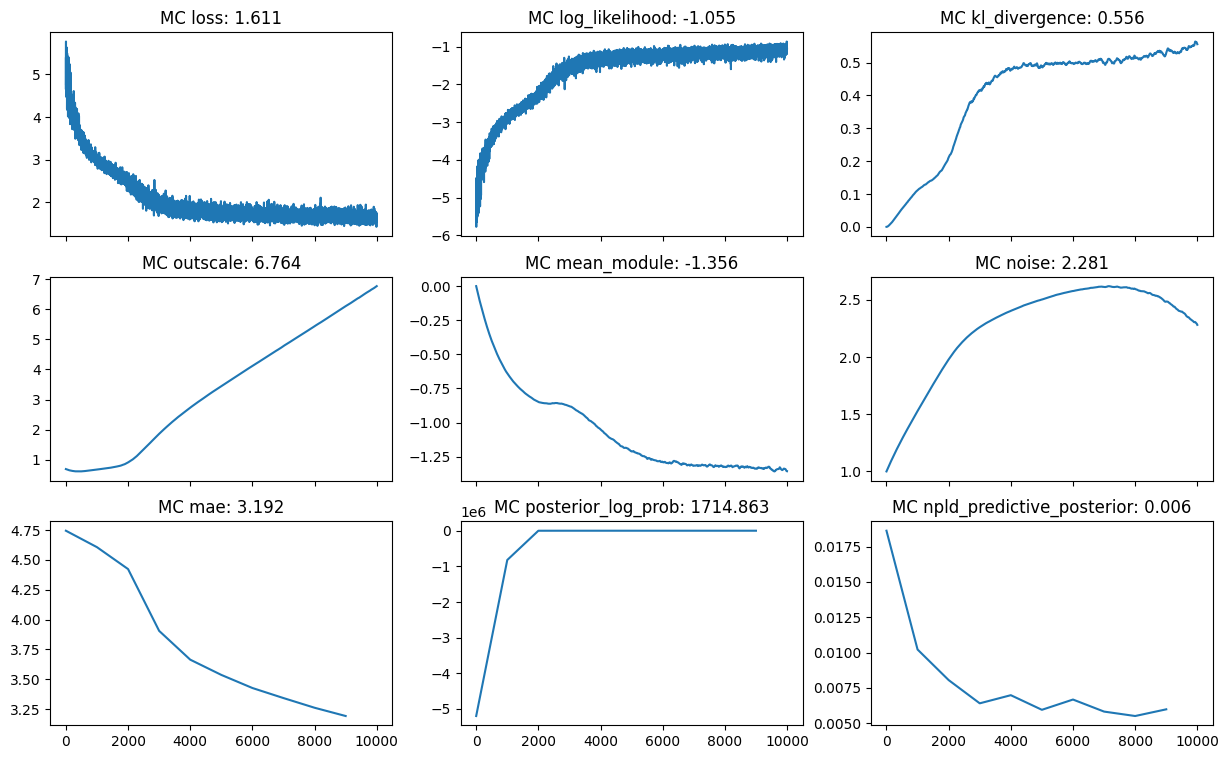

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


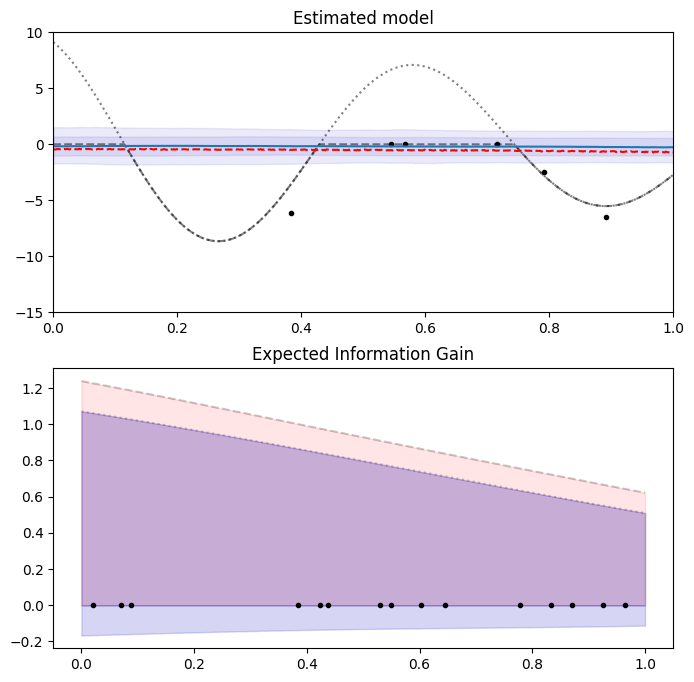

In [63]:
# retrain learner
model = GPModel(inducing_points=x[:,None])
likelihood = CensoredGaussianLikelihood(low=-100., high=MAX_VALUE)
loss = gpytorch.mlls.VariationalELBO(likelihood, model, beta=1., combine_terms=False, num_data=y.size(0))

optimizer = torch.optim.Adam([
      {'params': model.parameters()},
      {'params': likelihood.parameters()},
  ], lr=0.001)

model = model.to(device)
likelihood = likelihood.to(device)

training_results = train_learner(x[:,None], oracle(x), model, likelihood, loss, optimizer, 10000, 1000)
plot_metrics(training_results['logs'])
plot_result(trainig_results['model'], trainig_results['likelihood'])

  0%|          | 0/10 [00:00<?, ?it/s]


--Iter: 0
training learner: x_size torch.Size([5]), pool_size torch.Size([15])


  0%|          | 7/10000 [00:00<02:39, 62.60it/s]

loss 6.0145111083984375
log_likelihood -6.0145111083984375
kl_divergence 1.1920928955078125e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999999310821295
noise 1.0006322860717773


 10%|█         | 1013/10000 [00:13<02:08, 70.20it/s]

loss 3.543463706970215
log_likelihood -3.4192521572113037
kl_divergence 0.12421143054962158
log_prior 0.0
outscale 0.8080397844314575
mean_module -0.6356694102287292
noise 1.540087103843689


 20%|██        | 2013/10000 [00:27<01:50, 72.54it/s]

loss 2.4423940181732178
log_likelihood -2.0105502605438232
kl_divergence 0.43184369802474976
log_prior 0.0
outscale 1.5734686851501465
mean_module -0.7095949649810791
noise 1.9340124130249023


 30%|███       | 3013/10000 [00:40<01:35, 73.29it/s]

loss 1.9784350395202637
log_likelihood -1.3436282873153687
kl_divergence 0.6348068118095398
log_prior 0.0
outscale 2.569255828857422
mean_module -0.6153472065925598
noise 2.0811665058135986


 40%|████      | 4013/10000 [00:54<01:23, 71.96it/s]

loss 1.8946387767791748
log_likelihood -1.2507656812667847
kl_divergence 0.6438731551170349
log_prior 0.0
outscale 3.365769147872925
mean_module -0.7430959939956665
noise 2.1581146717071533


 50%|█████     | 5013/10000 [01:07<01:07, 73.40it/s]

loss 1.6175930500030518
log_likelihood -0.9954977035522461
kl_divergence 0.6220953464508057
log_prior 0.0
outscale 4.079904556274414
mean_module -0.9094518423080444
noise 2.211510181427002


 60%|██████    | 6013/10000 [01:21<00:55, 71.62it/s]

loss 1.5382975339889526
log_likelihood -0.9254462122917175
kl_divergence 0.6128513216972351
log_prior 0.0
outscale 4.772903919219971
mean_module -1.0030971765518188
noise 2.2363574504852295


 70%|███████   | 7013/10000 [01:34<00:40, 73.42it/s]

loss 1.5118430852890015
log_likelihood -0.9089064598083496
kl_divergence 0.6029366254806519
log_prior 0.0
outscale 5.473094940185547
mean_module -1.0501391887664795
noise 2.212047815322876


 80%|████████  | 8013/10000 [01:48<00:27, 72.51it/s]

loss 1.5306766033172607
log_likelihood -0.9227399230003357
kl_divergence 0.6079367399215698
log_prior 0.0
outscale 6.186386585235596
mean_module -1.0437406301498413
noise 2.107422113418579


 90%|█████████ | 9013/10000 [02:01<00:13, 73.15it/s]

loss 1.5856571197509766
log_likelihood -0.9541284441947937
kl_divergence 0.6315287351608276
log_prior 0.0
outscale 6.923367977142334
mean_module -1.0409122705459595
noise 1.891842007637024


100%|██████████| 10000/10000 [02:15<00:00, 74.02it/s]


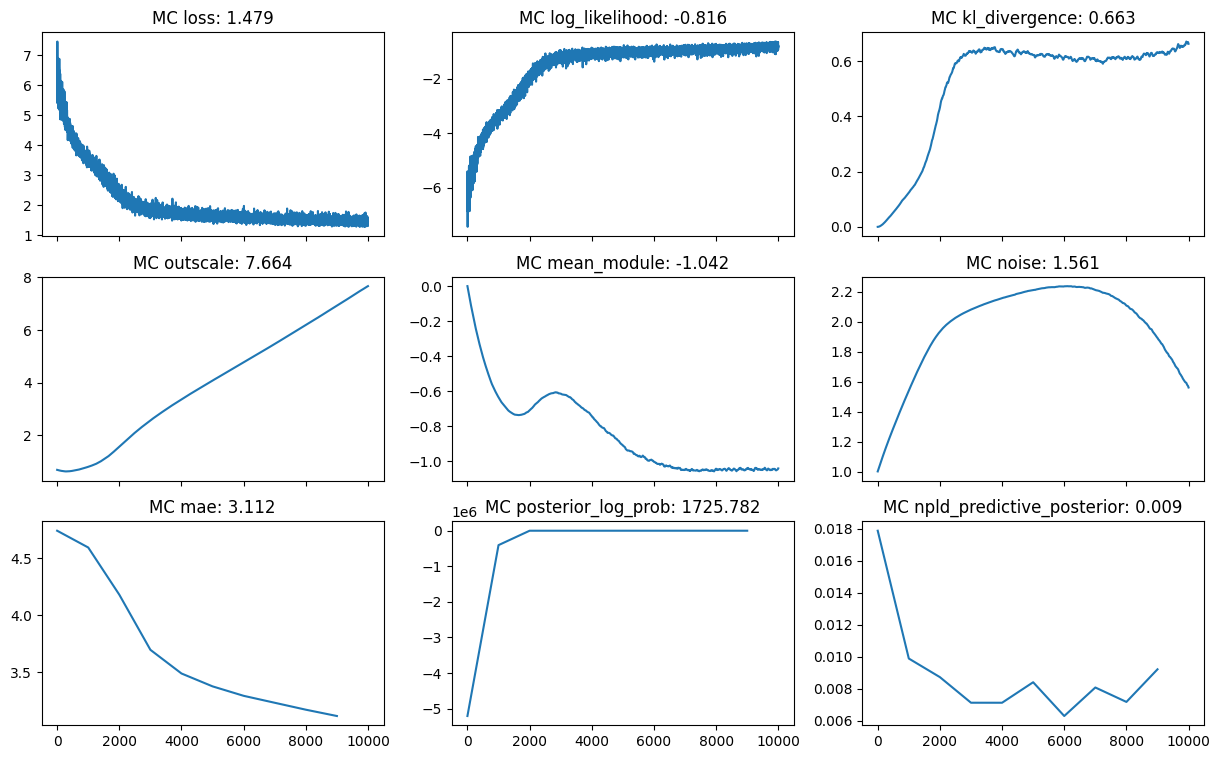

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 10%|█         | 1/10 [02:17<20:33, 137.08s/it]


--Iter: 0 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01715994, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 1
training learner: x_size torch.Size([6]), pool_size torch.Size([14])


  0%|          | 7/10000 [00:00<02:34, 64.79it/s]

loss 6.306520462036133
log_likelihood -6.306519508361816
kl_divergence 7.152557941481064e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999999310821295
noise 1.0006322860717773


 10%|█         | 1007/10000 [00:13<02:05, 71.76it/s]

loss 3.6151371002197266
log_likelihood -3.47049880027771
kl_divergence 0.14463821053504944
log_prior 0.0
outscale 0.851859986782074
mean_module -0.6880634427070618
noise 1.5318559408187866


 20%|██        | 2015/10000 [00:27<01:50, 72.25it/s]

loss 2.776118755340576
log_likelihood -2.3282833099365234
kl_divergence 0.44783538579940796
log_prior 0.0
outscale 1.4773023128509521
mean_module -0.8582432866096497
noise 1.934152603149414


 30%|███       | 3007/10000 [00:40<01:39, 70.60it/s]

loss 2.0644047260284424
log_likelihood -1.4729559421539307
kl_divergence 0.5914487242698669
log_prior 0.0
outscale 2.525395393371582
mean_module -0.8633289933204651
noise 2.1239211559295654


 40%|████      | 4007/10000 [00:53<01:23, 71.76it/s]

loss 2.065309524536133
log_likelihood -1.4476597309112549
kl_divergence 0.6176496744155884
log_prior 0.0
outscale 3.363485336303711
mean_module -1.0839869976043701
noise 2.2159950733184814


 50%|█████     | 5015/10000 [01:07<01:07, 73.44it/s]

loss 1.635327935218811
log_likelihood -1.0264606475830078
kl_divergence 0.6088672876358032
log_prior 0.0
outscale 4.0691328048706055
mean_module -1.3604625463485718
noise 2.2621068954467773


 60%|██████    | 6015/10000 [01:20<00:54, 72.95it/s]

loss 1.7010347843170166
log_likelihood -1.0869930982589722
kl_divergence 0.6140416264533997
log_prior 0.0
outscale 4.733292579650879
mean_module -1.561558485031128
noise 2.2673282623291016


 70%|███████   | 7012/10000 [01:34<00:40, 73.24it/s]

loss 1.6384742259979248
log_likelihood -1.0145304203033447
kl_divergence 0.6239437460899353
log_prior 0.0
outscale 5.406291484832764
mean_module -1.7027788162231445
noise 2.2071714401245117


 80%|████████  | 8012/10000 [01:47<00:27, 73.56it/s]

loss 1.9015281200408936
log_likelihood -1.2644445896148682
kl_divergence 0.6370834708213806
log_prior 0.0
outscale 6.101071834564209
mean_module -1.7930028438568115
noise 2.0384621620178223


 90%|█████████ | 9012/10000 [02:01<00:14, 69.38it/s]

loss 1.626086711883545
log_likelihood -0.9554485082626343
kl_divergence 0.6706382632255554
log_prior 0.0
outscale 6.814408302307129
mean_module -1.8566840887069702
noise 1.7297574281692505


100%|██████████| 10000/10000 [02:14<00:00, 74.37it/s]


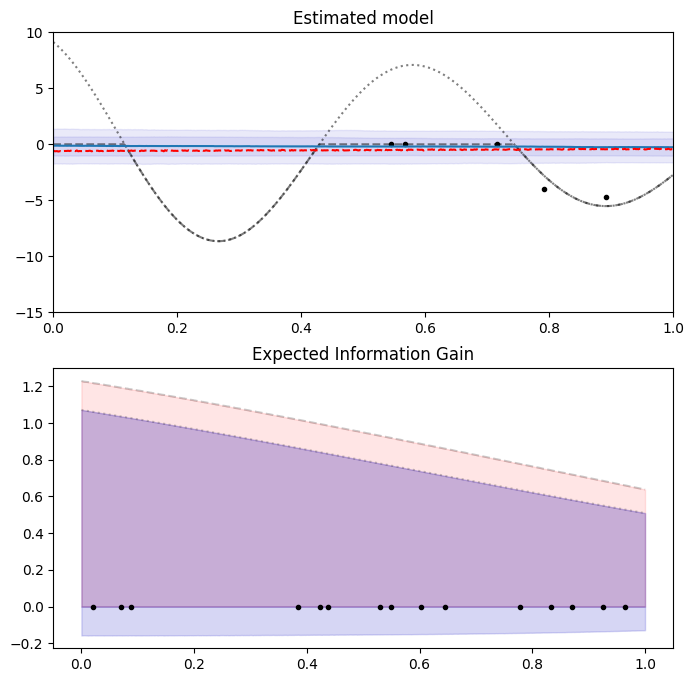

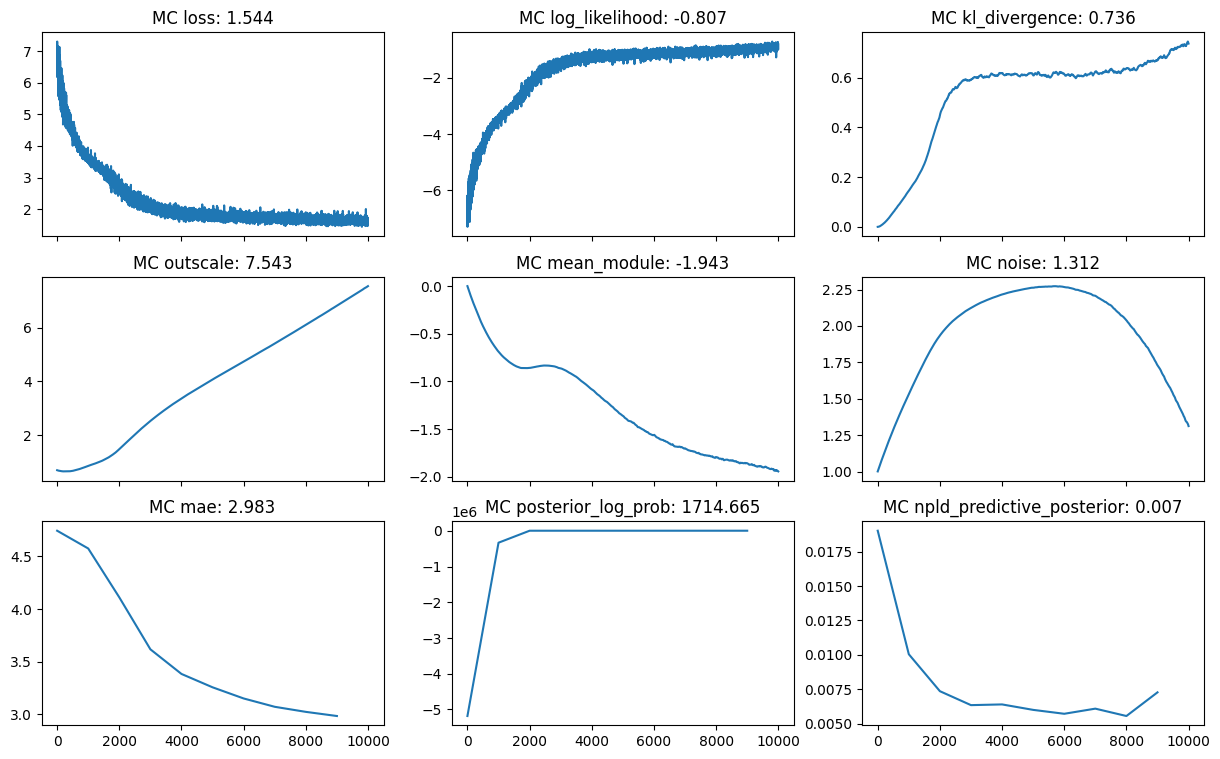

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 20%|██        | 2/10 [04:33<18:15, 136.96s/it]


--Iter: 1 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01708655, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 2
training learner: x_size torch.Size([7]), pool_size torch.Size([13])


  0%|          | 7/10000 [00:00<02:40, 62.26it/s]

loss 5.720766067504883
log_likelihood -5.720766067504883
kl_divergence 2.384185791015625e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0010000000474974513
noise 1.0006322860717773


 10%|█         | 1007/10000 [00:13<02:06, 70.98it/s]

loss 3.3409011363983154
log_likelihood -3.229424476623535
kl_divergence 0.11147671937942505
log_prior 0.0
outscale 0.7026401162147522
mean_module -0.6374977231025696
noise 1.5405575037002563


 20%|██        | 2007/10000 [00:27<01:56, 68.66it/s]

loss 2.30466628074646
log_likelihood -1.863715410232544
kl_divergence 0.440950870513916
log_prior 0.0
outscale 1.3280270099639893
mean_module -0.7628353238105774
noise 1.955790638923645


 30%|███       | 3007/10000 [00:40<01:39, 70.06it/s]

loss 1.7604345083236694
log_likelihood -1.2077175378799438
kl_divergence 0.5527169704437256
log_prior 0.0
outscale 2.380969524383545
mean_module -0.8383800387382507
noise 2.110877752304077


 40%|████      | 4015/10000 [00:54<01:22, 72.68it/s]

loss 1.611755132675171
log_likelihood -1.0524767637252808
kl_divergence 0.5592783689498901
log_prior 0.0
outscale 3.172638416290283
mean_module -1.1056808233261108
noise 2.1822779178619385


 50%|█████     | 5015/10000 [01:07<01:08, 72.93it/s]

loss 1.504813551902771
log_likelihood -0.9391826391220093
kl_divergence 0.5656309127807617
log_prior 0.0
outscale 3.865885019302368
mean_module -1.3829697370529175
noise 2.204850435256958


 60%|██████    | 6007/10000 [01:21<00:55, 71.39it/s]

loss 1.5219385623931885
log_likelihood -0.9601976275444031
kl_divergence 0.5617408752441406
log_prior 0.0
outscale 4.530078411102295
mean_module -1.5852612257003784
noise 2.167278528213501


 70%|███████   | 7015/10000 [01:34<00:40, 72.82it/s]

loss 1.5463886260986328
log_likelihood -0.9693978428840637
kl_divergence 0.5769907236099243
log_prior 0.0
outscale 5.208967685699463
mean_module -1.7191529273986816
noise 2.043875217437744


 80%|████████  | 8013/10000 [01:48<00:27, 71.47it/s]

loss 1.4848339557647705
log_likelihood -0.8857200741767883
kl_divergence 0.599113941192627
log_prior 0.0
outscale 5.907878875732422
mean_module -1.8292409181594849
noise 1.7908517122268677


 90%|█████████ | 9013/10000 [02:01<00:13, 71.39it/s]

loss 1.459540843963623
log_likelihood -0.8150568604469299
kl_divergence 0.6444840431213379
log_prior 0.0
outscale 6.616455078125
mean_module -1.9183611869812012
noise 1.4042104482650757


100%|██████████| 10000/10000 [02:15<00:00, 73.98it/s]


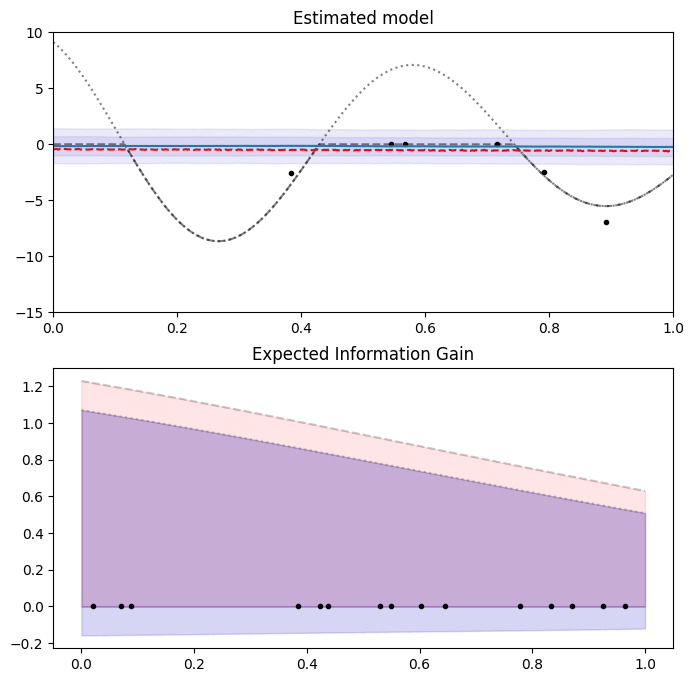

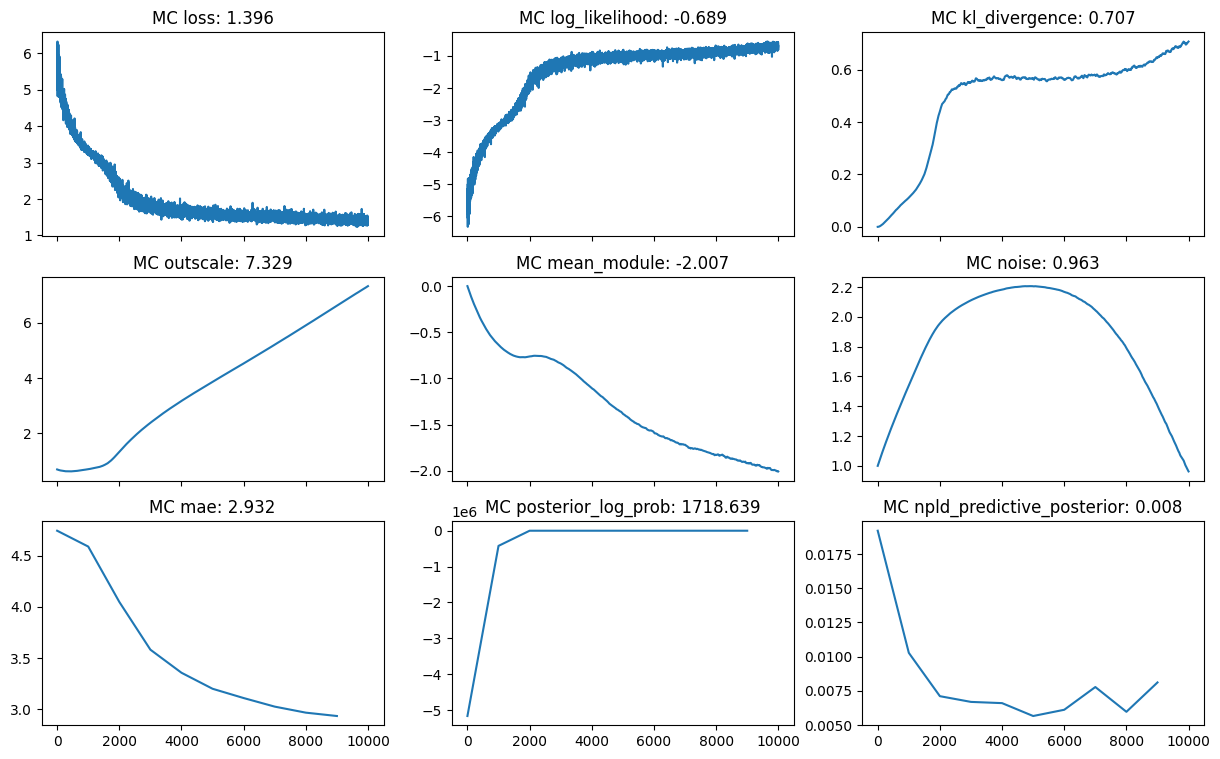

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 30%|███       | 3/10 [06:51<16:00, 137.17s/it]


--Iter: 2 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.0168724, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 3
training learner: x_size torch.Size([8]), pool_size torch.Size([12])


  0%|          | 7/10000 [00:00<02:35, 64.40it/s]

loss 4.834477424621582
log_likelihood -4.834476947784424
kl_divergence 4.238552548940788e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999998146668077
noise 1.0006322860717773


 10%|█         | 1007/10000 [00:13<02:03, 72.64it/s]

loss 2.845104932785034
log_likelihood -2.765047311782837
kl_divergence 0.08005767315626144
log_prior 0.0
outscale 0.5855330228805542
mean_module -0.5555165410041809
noise 1.5437533855438232


 20%|██        | 2007/10000 [00:27<01:52, 71.11it/s]

loss 2.121131181716919
log_likelihood -1.8400673866271973
kl_divergence 0.2810637056827545
log_prior 0.0
outscale 1.01692533493042
mean_module -0.6350469589233398
noise 1.9814831018447876


 30%|███       | 3007/10000 [00:40<01:40, 69.79it/s]

loss 1.6838793754577637
log_likelihood -1.241424560546875
kl_divergence 0.4424547553062439
log_prior 0.0
outscale 2.0173234939575195
mean_module -0.6607758402824402
noise 2.16854190826416


 40%|████      | 4007/10000 [00:54<01:26, 69.48it/s]

loss 1.6819379329681396
log_likelihood -1.2098593711853027
kl_divergence 0.4720785319805145
log_prior 0.0
outscale 2.8019216060638428
mean_module -0.8803096413612366
noise 2.2578248977661133


 50%|█████     | 5007/10000 [01:07<01:11, 69.93it/s]

loss 1.5562782287597656
log_likelihood -1.081840991973877
kl_divergence 0.4744371771812439
log_prior 0.0
outscale 3.5027544498443604
mean_module -1.069686770439148
noise 2.289661407470703


 60%|██████    | 6007/10000 [01:21<00:57, 69.40it/s]

loss 1.6456698179244995
log_likelihood -1.1572167873382568
kl_divergence 0.4884530305862427
log_prior 0.0
outscale 4.184459686279297
mean_module -1.2017630338668823
noise 2.2597880363464355


 70%|███████   | 7007/10000 [01:34<00:41, 71.87it/s]

loss 1.5519630908966064
log_likelihood -1.050382137298584
kl_divergence 0.5015810132026672
log_prior 0.0
outscale 4.876208782196045
mean_module -1.287907361984253
noise 2.1314799785614014


 80%|████████  | 8015/10000 [01:48<00:27, 72.59it/s]

loss 1.442840337753296
log_likelihood -0.9260891675949097
kl_divergence 0.5167511701583862
log_prior 0.0
outscale 5.586035251617432
mean_module -1.3541594743728638
noise 1.867791771888733


 90%|█████████ | 9007/10000 [02:01<00:14, 70.89it/s]

loss 1.4092023372650146
log_likelihood -0.8515377044677734
kl_divergence 0.5576645731925964
log_prior 0.0
outscale 6.330134868621826
mean_module -1.4394700527191162
noise 1.5065727233886719


100%|██████████| 10000/10000 [02:15<00:00, 73.96it/s]


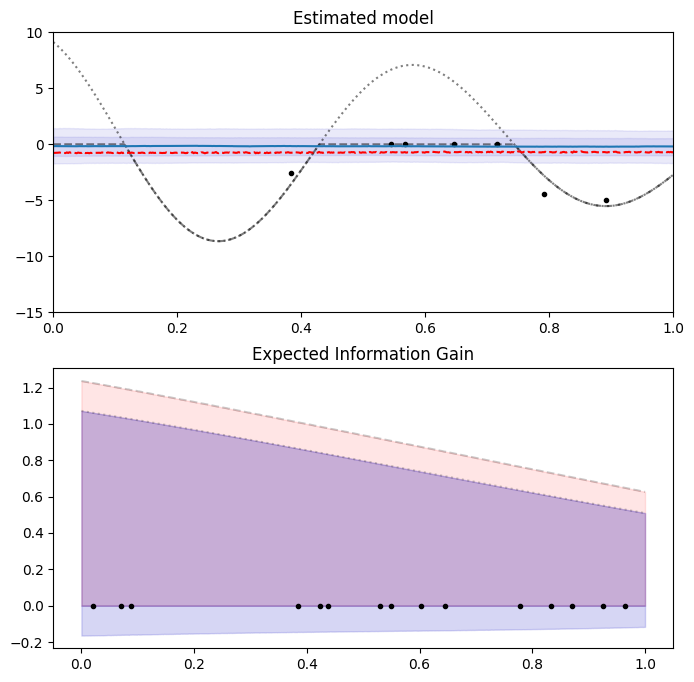

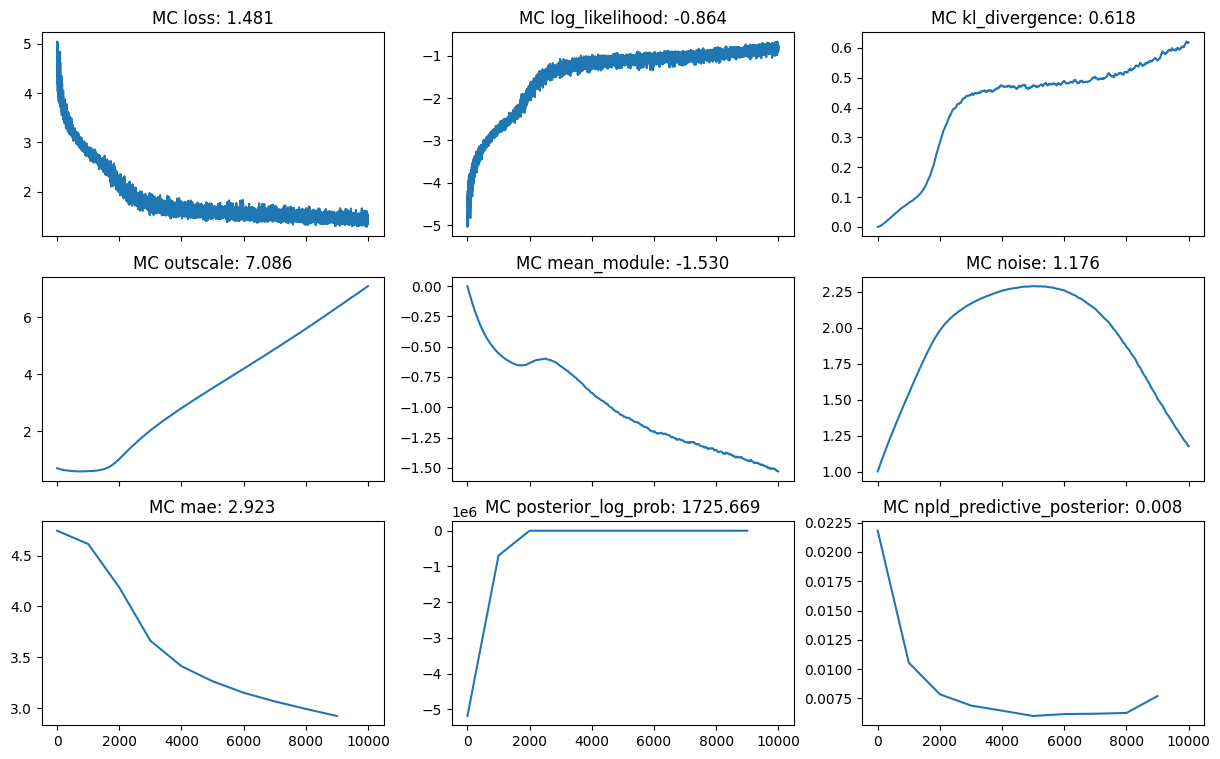

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 40%|████      | 4/10 [09:09<13:44, 137.36s/it]


--Iter: 3 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01700495, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 4
training learner: x_size torch.Size([9]), pool_size torch.Size([11])


  0%|          | 6/10000 [00:00<02:46, 59.94it/s]

loss 5.43601131439209
log_likelihood -5.43601131439209
kl_divergence 1.9073486612342094e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0010000000474974513
noise 1.0006322860717773


 10%|█         | 1014/10000 [00:13<02:04, 71.99it/s]

loss 3.293902635574341
log_likelihood -3.216040849685669
kl_divergence 0.0778617411851883
log_prior 0.0
outscale 0.6375442147254944
mean_module -0.5684072971343994
noise 1.5555553436279297


 20%|██        | 2014/10000 [00:27<01:51, 71.33it/s]

loss 2.3120815753936768
log_likelihood -1.9735463857650757
kl_divergence 0.3385351300239563
log_prior 0.0
outscale 1.196544885635376
mean_module -0.5825304388999939
noise 2.0172278881073


 30%|███       | 3006/10000 [00:40<01:40, 69.45it/s]

loss 1.7870402336120605
log_likelihood -1.2860409021377563
kl_divergence 0.5009992718696594
log_prior 0.0
outscale 2.255963087081909
mean_module -0.478547602891922
noise 2.2693052291870117


 40%|████      | 4007/10000 [00:54<01:25, 70.22it/s]

loss 1.7051762342453003
log_likelihood -1.1953123807907104
kl_divergence 0.5098638534545898
log_prior 0.0
outscale 3.0649616718292236
mean_module -0.5716579556465149
noise 2.4905004501342773


 50%|█████     | 5013/10000 [01:08<01:10, 70.34it/s]

loss 1.6522746086120605
log_likelihood -1.1637098789215088
kl_divergence 0.48856469988822937
log_prior 0.0
outscale 3.773496389389038
mean_module -0.6571807861328125
noise 2.7367563247680664


 60%|██████    | 6012/10000 [01:22<00:56, 70.90it/s]

loss 1.6267051696777344
log_likelihood -1.1513868570327759
kl_divergence 0.4753183424472809
log_prior 0.0
outscale 4.453739166259766
mean_module -0.6610676050186157
noise 3.0263009071350098


 70%|███████   | 7008/10000 [01:36<00:46, 64.75it/s]

loss 1.5425316095352173
log_likelihood -1.0893898010253906
kl_divergence 0.4531417787075043
log_prior 0.0
outscale 5.129978656768799
mean_module -0.6090335845947266
noise 3.368769407272339


 80%|████████  | 8010/10000 [01:50<00:29, 66.88it/s]

loss 1.443960189819336
log_likelihood -1.0214143991470337
kl_divergence 0.42254573106765747
log_prior 0.0
outscale 5.803477764129639
mean_module -0.5240587592124939
noise 3.761904239654541


 90%|█████████ | 9012/10000 [02:04<00:14, 69.75it/s]

loss 1.4073148965835571
log_likelihood -1.0010733604431152
kl_divergence 0.4062415063381195
log_prior 0.0
outscale 6.489867687225342
mean_module -0.4356417953968048
noise 4.2031168937683105


100%|██████████| 10000/10000 [02:17<00:00, 72.73it/s]


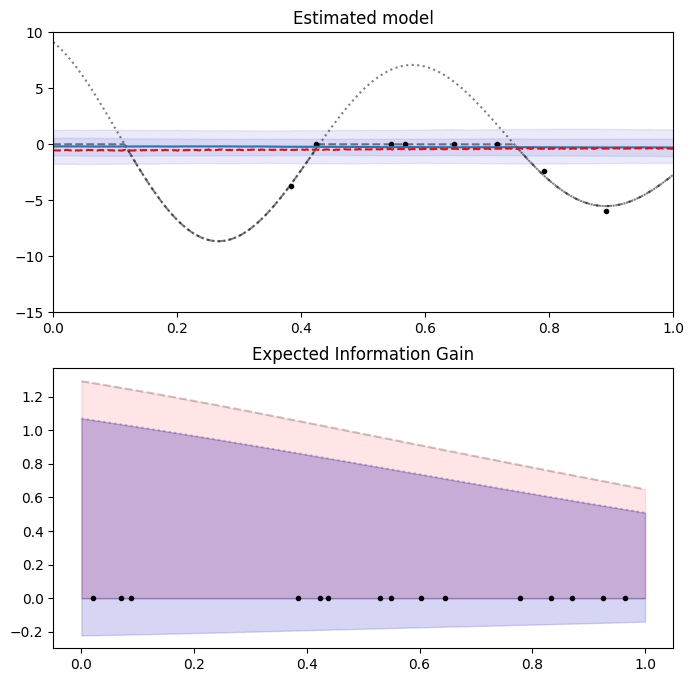

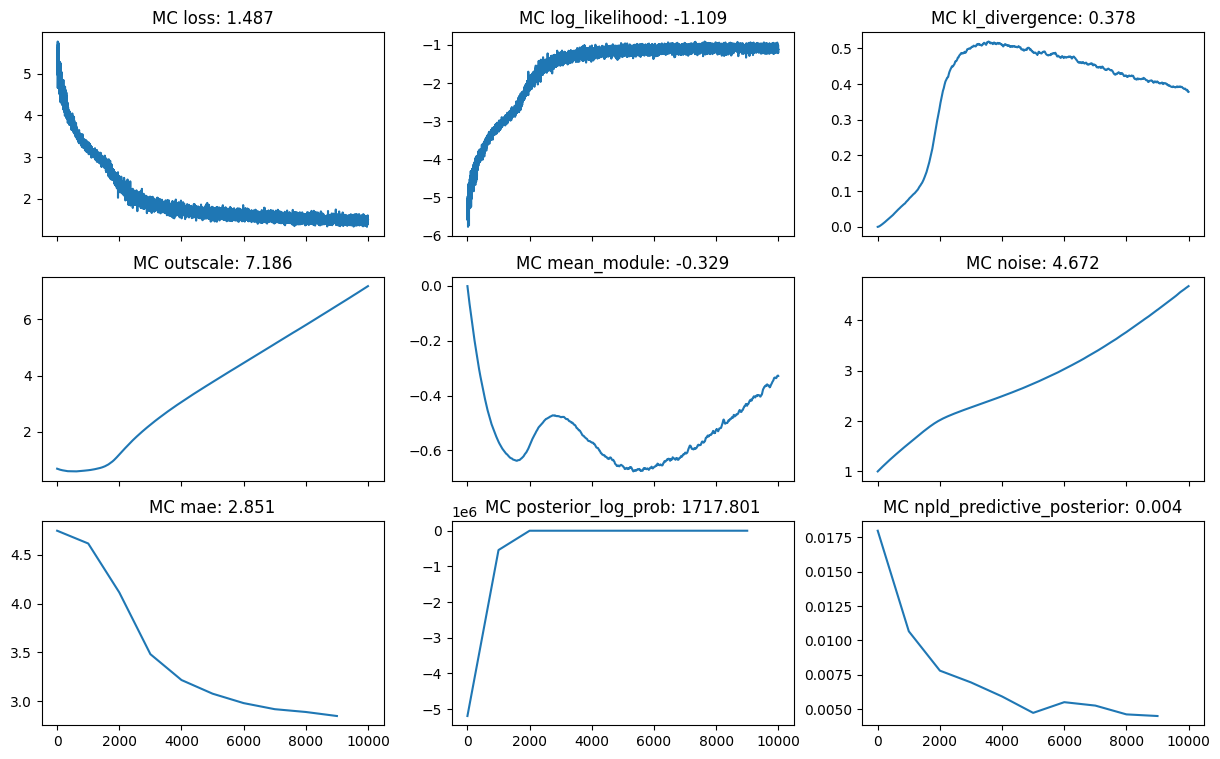

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 50%|█████     | 5/10 [11:28<11:31, 138.23s/it]


--Iter: 4 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01594963, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 5
training learner: x_size torch.Size([10]), pool_size torch.Size([10])


  0%|          | 7/10000 [00:00<02:36, 63.93it/s]

loss 4.1864213943481445
log_likelihood -4.186420917510986
kl_divergence 3.467906708465307e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999999310821295
noise 1.0006322860717773


 10%|█         | 1013/10000 [00:13<02:06, 70.95it/s]

loss 2.5177528858184814
log_likelihood -2.4366233348846436
kl_divergence 0.08112955093383789
log_prior 0.0
outscale 0.6441800594329834
mean_module -0.5561141967773438
noise 1.5339365005493164


 20%|██        | 2013/10000 [00:27<01:52, 71.08it/s]

loss 1.89646315574646
log_likelihood -1.5625015497207642
kl_divergence 0.3339615762233734
log_prior 0.0
outscale 1.256710171699524
mean_module -0.4824192225933075
noise 1.9171909093856812


 30%|███       | 3013/10000 [00:41<01:40, 69.79it/s]

loss 1.496678352355957
log_likelihood -1.0984084606170654
kl_divergence 0.398269921541214
log_prior 0.0
outscale 2.156247854232788
mean_module -0.32091817259788513
noise 2.0818259716033936


 40%|████      | 4012/10000 [00:55<01:22, 72.63it/s]

loss 1.52170991897583
log_likelihood -1.1139253377914429
kl_divergence 0.4077845513820648
log_prior 0.0
outscale 2.8867738246917725
mean_module -0.3788764476776123
noise 2.2115678787231445


 50%|█████     | 5008/10000 [01:08<01:09, 71.54it/s]

loss 1.545245885848999
log_likelihood -1.1354467868804932
kl_divergence 0.40979915857315063
log_prior 0.0
outscale 3.5393881797790527
mean_module -0.4537150263786316
noise 2.342586040496826


 60%|██████    | 6008/10000 [01:22<00:58, 68.70it/s]

loss 1.392181634902954
log_likelihood -0.9897525906562805
kl_divergence 0.40242907404899597
log_prior 0.0
outscale 4.167369365692139
mean_module -0.45474162697792053
noise 2.480642557144165


 70%|███████   | 7008/10000 [01:36<00:41, 71.28it/s]

loss 1.4493870735168457
log_likelihood -1.0604705810546875
kl_divergence 0.388916552066803
log_prior 0.0
outscale 4.794252395629883
mean_module -0.4182179570198059
noise 2.6244592666625977


 80%|████████  | 8008/10000 [01:49<00:28, 69.97it/s]

loss 1.275796890258789
log_likelihood -0.8955666422843933
kl_divergence 0.3802303075790405
log_prior 0.0
outscale 5.423516273498535
mean_module -0.36448901891708374
noise 2.75978422164917


 90%|█████████ | 9008/10000 [02:03<00:13, 71.42it/s]

loss 1.4199535846710205
log_likelihood -1.0417200326919556
kl_divergence 0.37823358178138733
log_prior 0.0
outscale 6.053782939910889
mean_module -0.3058463931083679
noise 2.8812952041625977


100%|██████████| 10000/10000 [02:16<00:00, 73.14it/s]


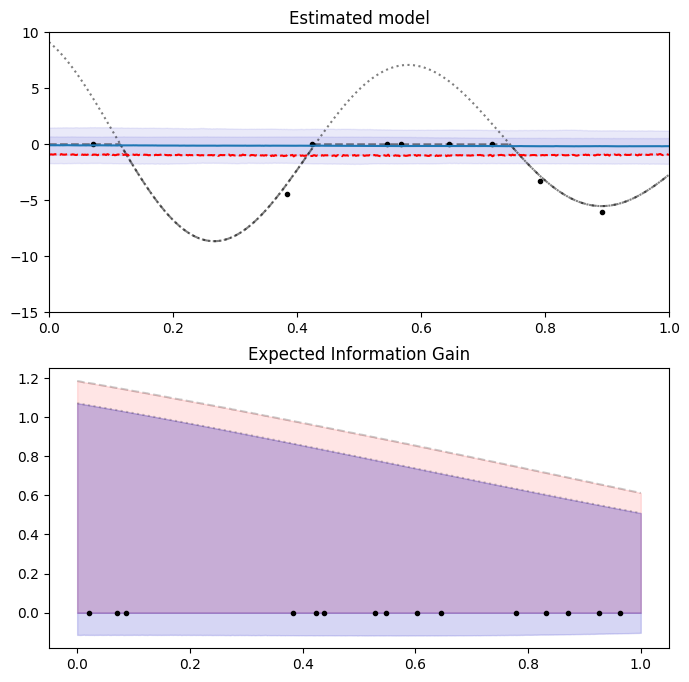

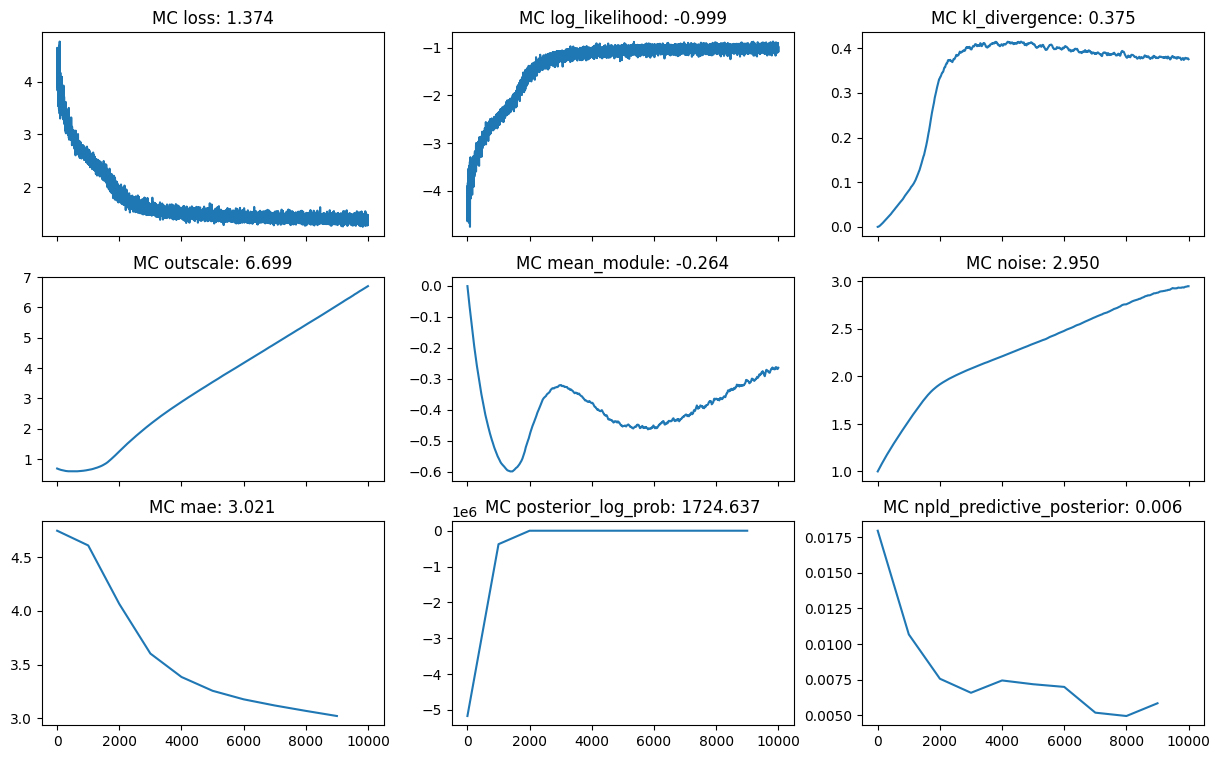

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 60%|██████    | 6/10 [13:47<09:14, 138.56s/it]


--Iter: 5 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01791577, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 6
training learner: x_size torch.Size([11]), pool_size torch.Size([9])


  0%|          | 7/10000 [00:00<02:39, 62.78it/s]

loss 4.591794013977051
log_likelihood -4.591794013977051
kl_divergence 1.5894572413799324e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999998146668077
noise 1.0006322860717773


 10%|█         | 1007/10000 [00:13<02:06, 71.25it/s]

loss 2.648566246032715
log_likelihood -2.557497024536133
kl_divergence 0.09106922149658203
log_prior 0.0
outscale 0.77570641040802
mean_module -0.6261597275733948
noise 1.5028020143508911


 20%|██        | 2014/10000 [00:27<01:53, 70.58it/s]

loss 1.9260886907577515
log_likelihood -1.596414566040039
kl_divergence 0.32967409491539
log_prior 0.0
outscale 1.397796630859375
mean_module -0.6136689782142639
noise 1.8086113929748535


 30%|███       | 3014/10000 [00:41<01:39, 70.19it/s]

loss 1.6259900331497192
log_likelihood -1.2275707721710205
kl_divergence 0.39841923117637634
log_prior 0.0
outscale 2.233539342880249
mean_module -0.4104810953140259
noise 1.8574315309524536


 40%|████      | 4014/10000 [00:54<01:26, 69.28it/s]

loss 1.5402024984359741
log_likelihood -1.11652410030365
kl_divergence 0.4236783981323242
log_prior 0.0
outscale 2.9545631408691406
mean_module -0.42416390776634216
noise 1.8073662519454956


 50%|█████     | 5012/10000 [01:08<01:09, 71.63it/s]

loss 1.4133145809173584
log_likelihood -0.9747451543807983
kl_divergence 0.43856939673423767
log_prior 0.0
outscale 3.590330123901367
mean_module -0.5299401879310608
noise 1.6789706945419312


 60%|██████    | 6012/10000 [01:22<00:57, 69.62it/s]

loss 1.4451154470443726
log_likelihood -0.9868927001953125
kl_divergence 0.45822271704673767
log_prior 0.0
outscale 4.186107158660889
mean_module -0.615938663482666
noise 1.4737634658813477


 70%|███████   | 7012/10000 [01:35<00:41, 72.35it/s]

loss 1.350125789642334
log_likelihood -0.8625105619430542
kl_divergence 0.48761528730392456
log_prior 0.0
outscale 4.76699686050415
mean_module -0.6705699563026428
noise 1.2323325872421265


 80%|████████  | 8011/10000 [01:49<00:28, 69.96it/s]

loss 1.3896007537841797
log_likelihood -0.879648745059967
kl_divergence 0.5099520087242126
log_prior 0.0
outscale 5.33314847946167
mean_module -0.7089657187461853
noise 1.0395358800888062


 90%|█████████ | 9010/10000 [02:03<00:13, 71.23it/s]

loss 1.3134465217590332
log_likelihood -0.7965104579925537
kl_divergence 0.5169360041618347
log_prior 0.0
outscale 5.8651814460754395
mean_module -0.7168740630149841
noise 0.9515547752380371


100%|██████████| 10000/10000 [02:16<00:00, 73.24it/s]


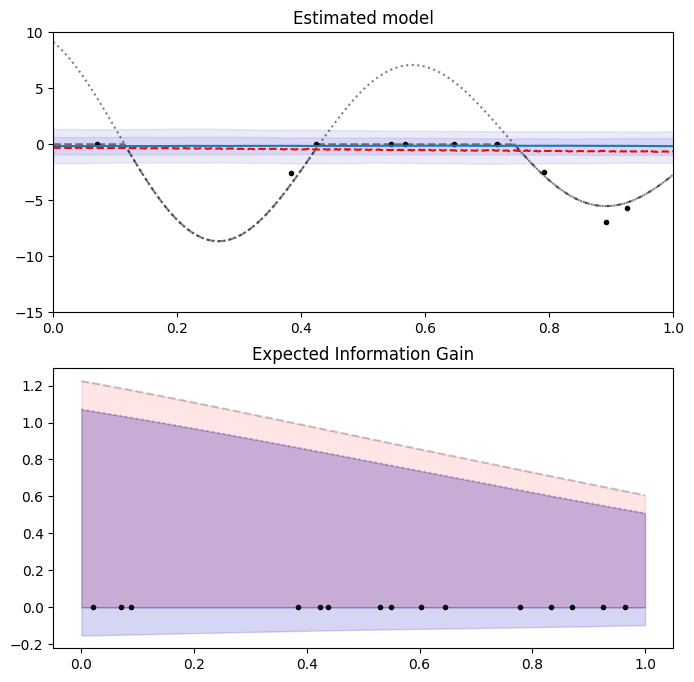

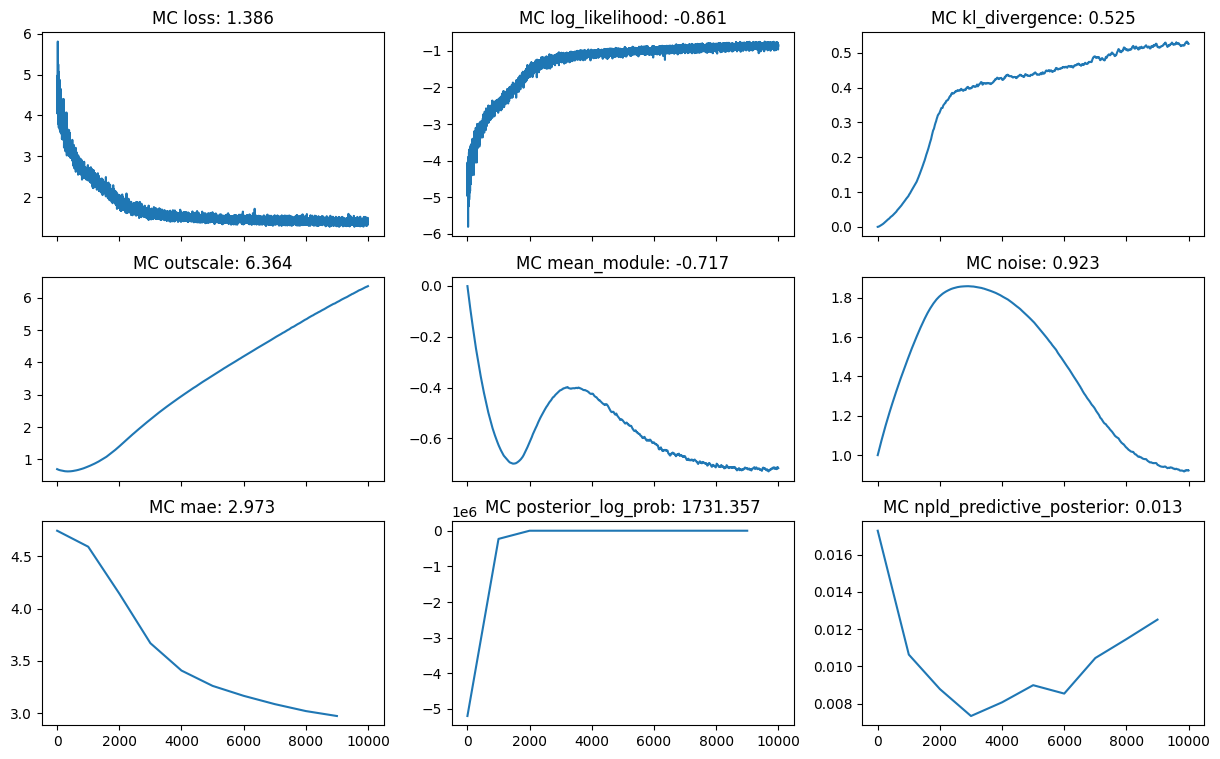

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 70%|███████   | 7/10 [16:06<06:55, 138.65s/it]


--Iter: 6 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01647779, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 7
training learner: x_size torch.Size([12]), pool_size torch.Size([8])


  0%|          | 6/10000 [00:00<02:46, 59.94it/s]

loss 6.577669620513916
log_likelihood -6.5776686668396
kl_divergence 8.436350071860943e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999999310821295
noise 1.0006322860717773


 10%|█         | 1012/10000 [00:13<02:06, 71.06it/s]

loss 3.454655647277832
log_likelihood -3.353168487548828
kl_divergence 0.10148705542087555
log_prior 0.0
outscale 0.9025409817695618
mean_module -0.6870675086975098
noise 1.517176628112793


 20%|██        | 2012/10000 [00:27<01:53, 70.65it/s]

loss 2.2332348823547363
log_likelihood -1.874704122543335
kl_divergence 0.3585306406021118
log_prior 0.0
outscale 1.5583707094192505
mean_module -0.7822893261909485
noise 1.8668595552444458


 30%|███       | 3012/10000 [00:41<01:37, 71.54it/s]

loss 1.8059643507003784
log_likelihood -1.3621890544891357
kl_divergence 0.44377532601356506
log_prior 0.0
outscale 2.439504623413086
mean_module -0.6267575025558472
noise 2.028435468673706


 40%|████      | 4012/10000 [00:54<01:24, 71.09it/s]

loss 1.7441227436065674
log_likelihood -1.259286642074585
kl_divergence 0.48483607172966003
log_prior 0.0
outscale 3.227309226989746
mean_module -0.6096804141998291
noise 2.0744636058807373


 50%|█████     | 5012/10000 [01:08<01:09, 71.44it/s]

loss 1.6315289735794067
log_likelihood -1.138338327407837
kl_divergence 0.4931906461715698
log_prior 0.0
outscale 3.9104435443878174
mean_module -0.7273768186569214
noise 2.0589089393615723


 60%|██████    | 6012/10000 [01:22<00:55, 72.42it/s]

loss 1.6861186027526855
log_likelihood -1.1931872367858887
kl_divergence 0.49293139576911926
log_prior 0.0
outscale 4.546201229095459
mean_module -0.8941150903701782
noise 1.9900078773498535


 70%|███████   | 7012/10000 [01:35<00:41, 71.63it/s]

loss 1.609799861907959
log_likelihood -1.0993455648422241
kl_divergence 0.5104543566703796
log_prior 0.0
outscale 5.177392959594727
mean_module -1.0270072221755981
noise 1.8615390062332153


 80%|████████  | 8011/10000 [01:49<00:28, 68.89it/s]

loss 1.5614298582077026
log_likelihood -1.0302722454071045
kl_divergence 0.5311576128005981
log_prior 0.0
outscale 5.819260120391846
mean_module -1.083961844444275
noise 1.667785406112671


 90%|█████████ | 9011/10000 [02:02<00:13, 71.36it/s]

loss 1.48854398727417
log_likelihood -0.927769660949707
kl_divergence 0.5607743859291077
log_prior 0.0
outscale 6.480292320251465
mean_module -1.1121268272399902
noise 1.439725637435913


100%|██████████| 10000/10000 [02:16<00:00, 73.26it/s]


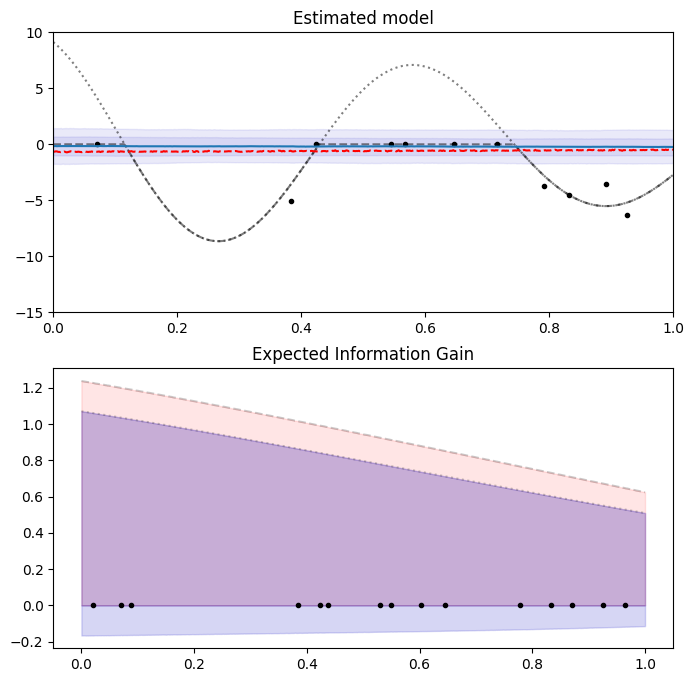

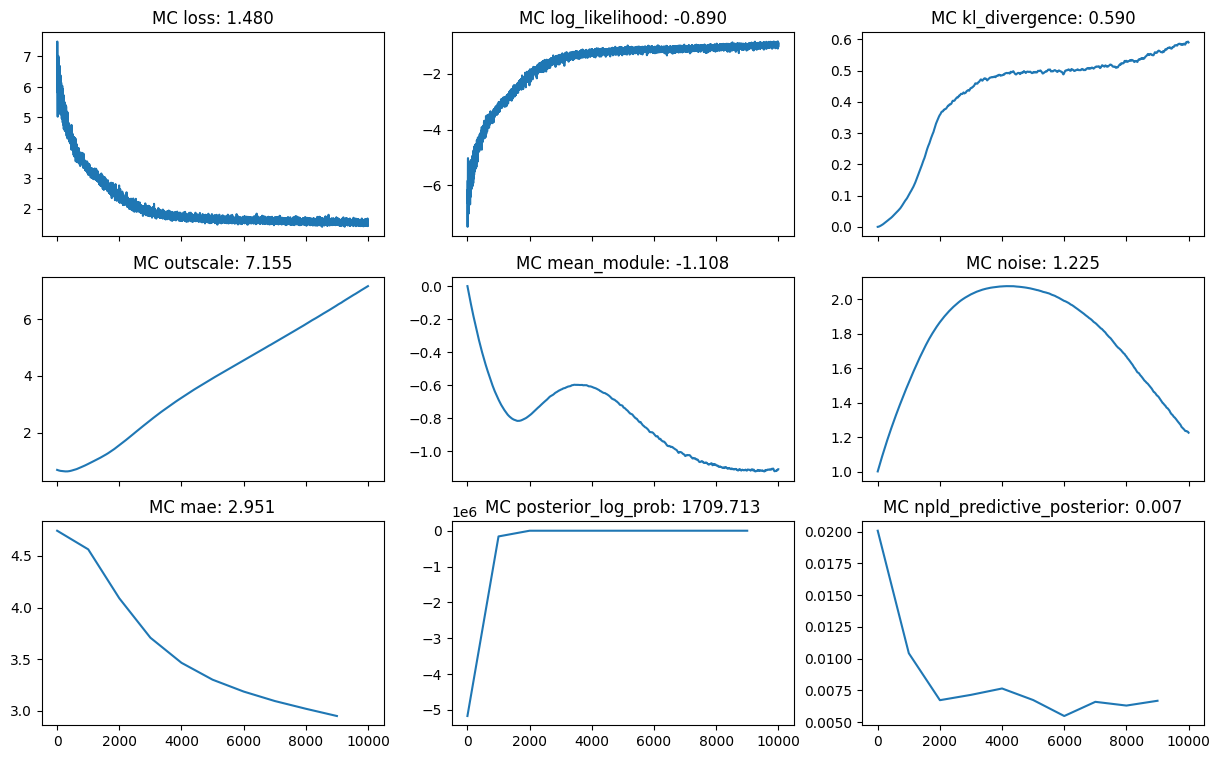

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 80%|████████  | 8/10 [18:25<04:37, 138.68s/it]


--Iter: 7 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01617238, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 8
training learner: x_size torch.Size([13]), pool_size torch.Size([7])


  0%|          | 0/10000 [00:00<?, ?it/s]

loss 6.395813465118408
log_likelihood -6.39581298828125
kl_divergence 5.449567765936081e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999999310821295
noise 1.0006322860717773


 10%|█         | 1007/10000 [00:14<02:08, 69.93it/s]

loss 3.4199094772338867
log_likelihood -3.3177709579467773
kl_divergence 0.10213842242956161
log_prior 0.0
outscale 0.8818486928939819
mean_module -0.6441547870635986
noise 1.5314298868179321


 20%|██        | 2007/10000 [00:27<01:56, 68.57it/s]

loss 2.0715713500976562
log_likelihood -1.6207243204116821
kl_divergence 0.4508470296859741
log_prior 0.0
outscale 1.7553117275238037
mean_module -0.617075502872467
noise 1.8434652090072632


 30%|███       | 3014/10000 [00:41<01:40, 69.43it/s]

loss 1.7064628601074219
log_likelihood -1.1966756582260132
kl_divergence 0.5097872018814087
log_prior 0.0
outscale 2.5795936584472656
mean_module -0.4224431812763214
noise 1.9368274211883545


 40%|████      | 4013/10000 [00:55<01:23, 72.10it/s]

loss 1.5749070644378662
log_likelihood -1.0601370334625244
kl_divergence 0.514769971370697
log_prior 0.0
outscale 3.303591728210449
mean_module -0.44052979350090027
noise 1.9796555042266846


 50%|█████     | 5013/10000 [01:09<01:09, 72.19it/s]

loss 1.4617769718170166
log_likelihood -0.9569762945175171
kl_divergence 0.5048006772994995
log_prior 0.0
outscale 3.973342180252075
mean_module -0.5794033408164978
noise 1.992598056793213


 60%|██████    | 6013/10000 [01:22<00:56, 70.66it/s]

loss 1.4696582555770874
log_likelihood -0.9703918099403381
kl_divergence 0.49926644563674927
log_prior 0.0
outscale 4.628540515899658
mean_module -0.735480546951294
noise 1.9689679145812988


 70%|███████   | 7013/10000 [01:36<00:42, 70.11it/s]

loss 1.449428915977478
log_likelihood -0.9499589800834656
kl_divergence 0.49946990609169006
log_prior 0.0
outscale 5.290931701660156
mean_module -0.8567621111869812
noise 1.8871588706970215


 80%|████████  | 8013/10000 [01:50<00:28, 70.39it/s]

loss 1.3867008686065674
log_likelihood -0.8808809518814087
kl_divergence 0.5058199763298035
log_prior 0.0
outscale 5.969697952270508
mean_module -0.9232312440872192
noise 1.7327195405960083


 90%|█████████ | 9013/10000 [02:03<00:13, 71.10it/s]

loss 1.3429980278015137
log_likelihood -0.8133242130279541
kl_divergence 0.5296737551689148
log_prior 0.0
outscale 6.675610065460205
mean_module -0.947234570980072
noise 1.502178430557251


100%|██████████| 10000/10000 [02:17<00:00, 72.73it/s]


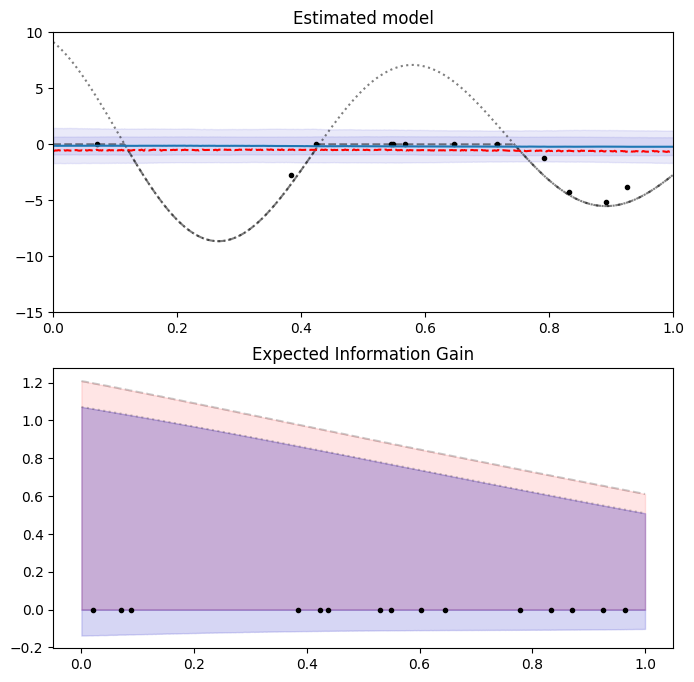

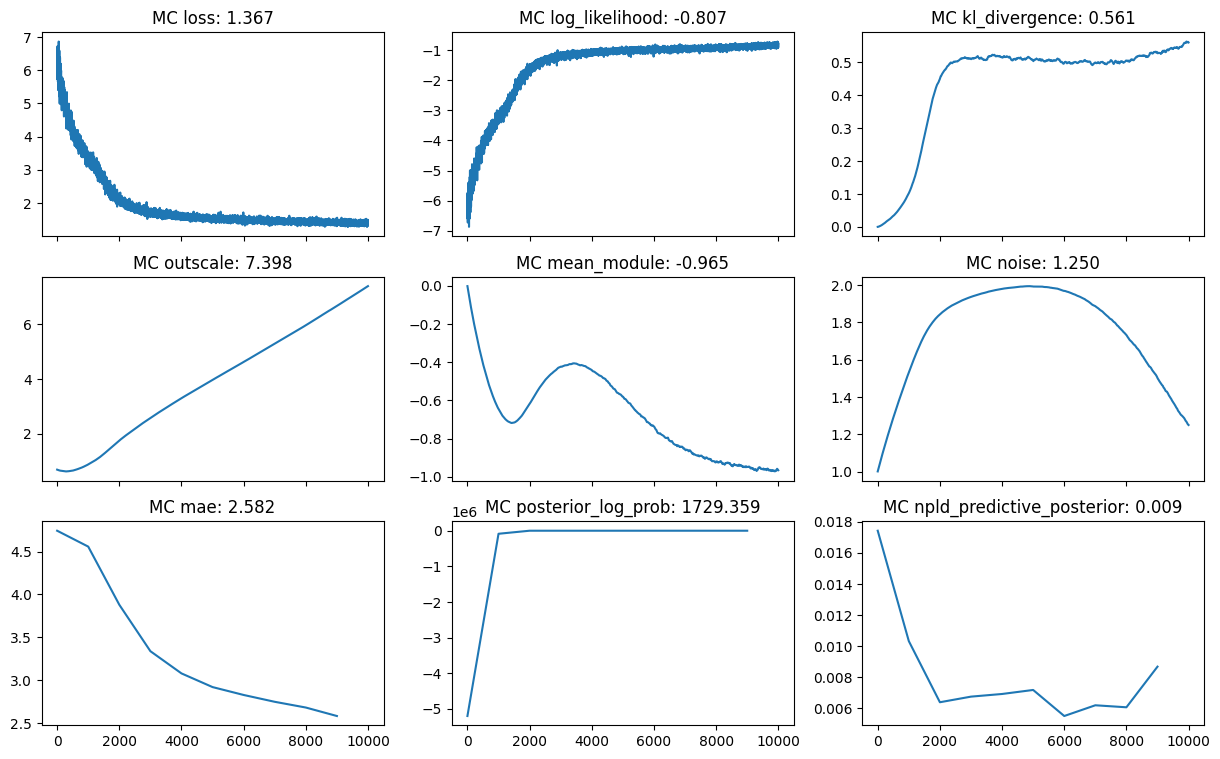

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 90%|█████████ | 9/10 [20:45<02:19, 139.04s/it]


--Iter: 8 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01713145, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 9
training learner: x_size torch.Size([14]), pool_size torch.Size([6])


  0%|          | 6/10000 [00:00<02:47, 59.75it/s]

loss 5.286032199859619
log_likelihood -5.286031723022461
kl_divergence 2.8610230629055877e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999999310821295
noise 1.0006322860717773


 10%|█         | 1011/10000 [00:13<02:10, 68.81it/s]

loss 2.8181686401367188
log_likelihood -2.730053663253784
kl_divergence 0.08811505883932114
log_prior 0.0
outscale 0.8714256286621094
mean_module -0.6497699618339539
noise 1.5148825645446777


 20%|██        | 2011/10000 [00:27<01:51, 71.71it/s]

loss 1.905609130859375
log_likelihood -1.5555243492126465
kl_divergence 0.3500848412513733
log_prior 0.0
outscale 1.6440633535385132
mean_module -0.6229819059371948
noise 1.7984905242919922


 30%|███       | 3011/10000 [00:41<01:37, 71.78it/s]

loss 1.5120720863342285
log_likelihood -1.1021521091461182
kl_divergence 0.40991994738578796
log_prior 0.0
outscale 2.4092421531677246
mean_module -0.37144288420677185
noise 1.8241287469863892


 40%|████      | 4011/10000 [00:55<01:25, 69.99it/s]

loss 1.4402433633804321
log_likelihood -1.0089777708053589
kl_divergence 0.43126559257507324
log_prior 0.0
outscale 3.0876762866973877
mean_module -0.31173041462898254
noise 1.7509982585906982


 50%|█████     | 5011/10000 [01:08<01:10, 70.50it/s]

loss 1.343466877937317
log_likelihood -0.9046971797943115
kl_divergence 0.438769668340683
log_prior 0.0
outscale 3.7172021865844727
mean_module -0.37989726662635803
noise 1.597054362297058


 60%|██████    | 6009/10000 [01:22<00:55, 71.62it/s]

loss 1.2702627182006836
log_likelihood -0.8094736337661743
kl_divergence 0.46078914403915405
log_prior 0.0
outscale 4.331003189086914
mean_module -0.486345112323761
noise 1.3442769050598145


 70%|███████   | 7009/10000 [01:36<00:42, 69.67it/s]

loss 1.2096256017684937
log_likelihood -0.71820467710495
kl_divergence 0.4914209544658661
log_prior 0.0
outscale 4.939317226409912
mean_module -0.556999146938324
noise 1.0054320096969604


 80%|████████  | 8009/10000 [01:49<00:27, 71.42it/s]

loss 1.1401399374008179
log_likelihood -0.5827009677886963
kl_divergence 0.5574389696121216
log_prior 0.0
outscale 5.548085689544678
mean_module -0.5997712016105652
noise 0.6741691827774048


 90%|█████████ | 9007/10000 [02:03<00:14, 70.54it/s]

loss 1.167212963104248
log_likelihood -0.5835630297660828
kl_divergence 0.5836499929428101
log_prior 0.0
outscale 5.665200233459473
mean_module -0.5736013650894165
noise 0.6154957413673401


100%|██████████| 10000/10000 [02:17<00:00, 72.80it/s]


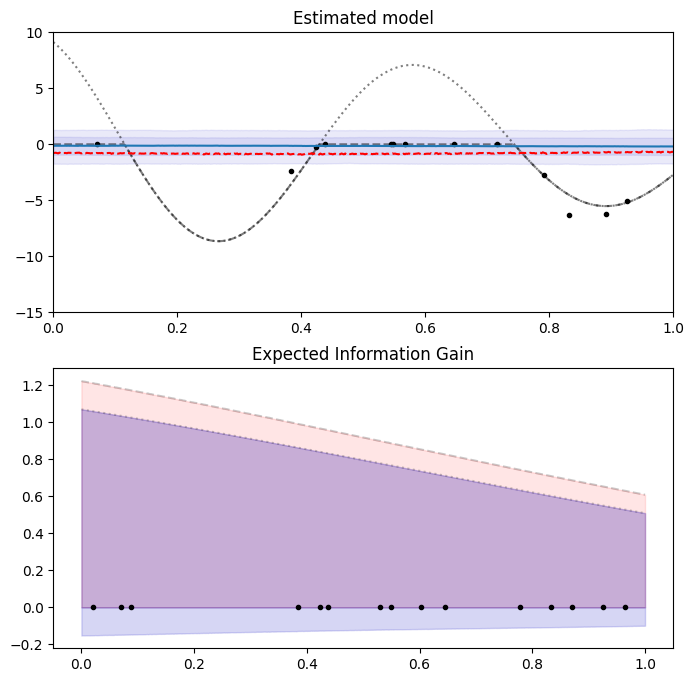

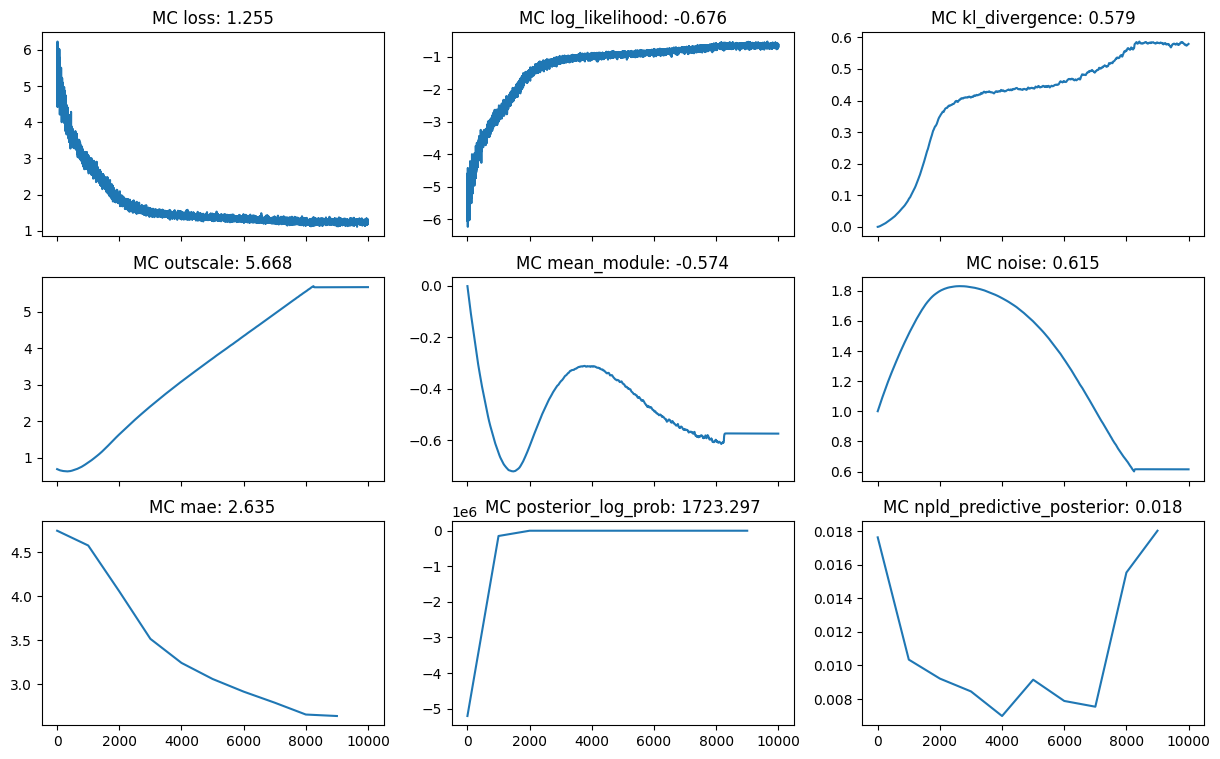

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
100%|██████████| 10/10 [23:05<00:00, 138.51s/it]



--Iter: 9 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01463009, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---


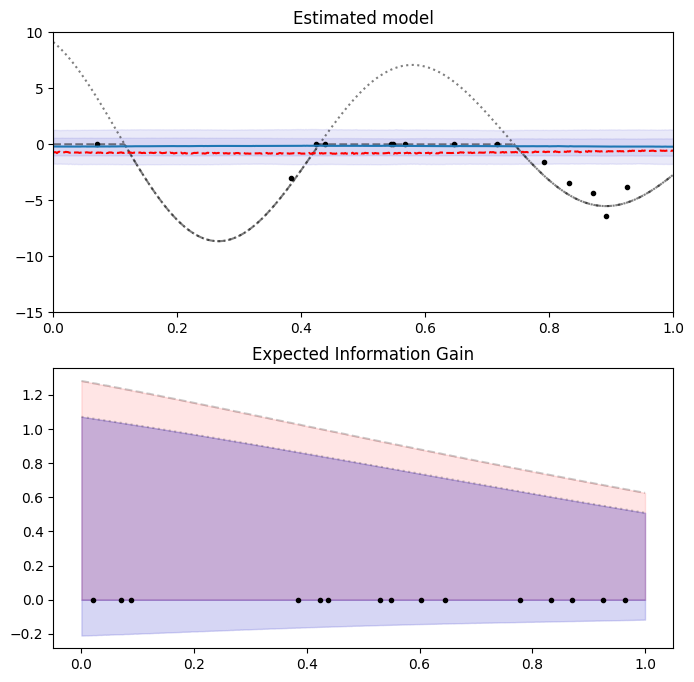

In [72]:
### training loop

# AL loop
steps = 10
pbar = tqdm.tqdm(range(steps), position=0, leave=True)
results_dict = {}

# data
x_pool = x_pool_init
x = x_init[idx_init]
y_ = oracle(x)

# learner
num_epochs_ = 10000
print_eval_ = 1000
acquisition_fcn = random_acquisition

for iter_ in pbar:
  print('\n--Iter: %s'%(iter_))
  print("training learner: x_size %s, pool_size %s"%(x.size(), x_pool.size()))

  model = GPModel(inducing_points=x[:,None])
  likelihood = CensoredGaussianLikelihood(low=-100., high=MAX_VALUE)
  loss = gpytorch.mlls.VariationalELBO(likelihood, model, beta=1., combine_terms=False, num_data=y.size(0))

  optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.001)

  model = model.to(device)
  likelihood = likelihood.to(device)

  training_results = train_learner(x[:,None], oracle(x), model, likelihood, loss, optimizer, num_epochs_, print_eval_)
  performance = evaluate_learner(trainig_results['model'], trainig_results['likelihood'], domain[:, None], y_test)

  plot_metrics(training_results['logs'])
  plot_result(trainig_results['model'], trainig_results['likelihood'])

  print("\n--Iter: %s performance:"%(iter_))
  pprint.pprint(performance)

  # query new point
  idx_new_, x_new = acquisition_fcn(x_pool)

  # label the new point and exclude from the pool
  x_pool = update_pool(x_pool, idx_new_)
  x, y = update_labeled_set(x, x_new, oracle)
  print('--- pool updated ---')

  results_dict[iter_] = {
      'model': trainig_results['model'],
      'likelihood': trainig_results['likelihood'],
      'logs': training_results['logs'],
      'performance': performance,
      'querry': [idx_new_, x_new],
    }

results_dict_random = results_dict

# AL: BALD loop

In [73]:
def bald_score(x, f_preds, y_preds, samples_ = 1000):
  posterior_sample = f_preds.sample_n(samples_)
  entropy = likelihood(x[:,None]).entropy().numpy(force=True).reshape(-1)
  expectation_entropy_wrt_psoterior = pred_samples * entropy
  bald_score = torch.Tensor(entropy) - expectation_entropy_wrt_psoterior.mean(0)
  return bald_score

def bald_acquisition(x, f_preds, y_preds, batch_=1):
  bald = bald_score(x, f_preds, y_preds)
  # TODO: implement of top k argmaxs to select batch
  idx_ =  torch.argmax(bald)
  return idx_, bald[idx_]

  0%|          | 0/10 [00:00<?, ?it/s]


--Iter: 0
training learner: x_size torch.Size([5]), pool_size torch.Size([15])


  0%|          | 7/10000 [00:00<02:39, 62.60it/s]

loss 6.0145111083984375
log_likelihood -6.0145111083984375
kl_divergence 1.1920928955078125e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999999310821295
noise 1.0006322860717773


 10%|█         | 1013/10000 [00:13<02:08, 70.20it/s]

loss 3.543463706970215
log_likelihood -3.4192521572113037
kl_divergence 0.12421143054962158
log_prior 0.0
outscale 0.8080397844314575
mean_module -0.6356694102287292
noise 1.540087103843689


 20%|██        | 2013/10000 [00:27<01:50, 72.54it/s]

loss 2.4423940181732178
log_likelihood -2.0105502605438232
kl_divergence 0.43184369802474976
log_prior 0.0
outscale 1.5734686851501465
mean_module -0.7095949649810791
noise 1.9340124130249023


 30%|███       | 3013/10000 [00:40<01:35, 73.29it/s]

loss 1.9784350395202637
log_likelihood -1.3436282873153687
kl_divergence 0.6348068118095398
log_prior 0.0
outscale 2.569255828857422
mean_module -0.6153472065925598
noise 2.0811665058135986


 40%|████      | 4013/10000 [00:54<01:23, 71.96it/s]

loss 1.8946387767791748
log_likelihood -1.2507656812667847
kl_divergence 0.6438731551170349
log_prior 0.0
outscale 3.365769147872925
mean_module -0.7430959939956665
noise 2.1581146717071533


 50%|█████     | 5013/10000 [01:07<01:07, 73.40it/s]

loss 1.6175930500030518
log_likelihood -0.9954977035522461
kl_divergence 0.6220953464508057
log_prior 0.0
outscale 4.079904556274414
mean_module -0.9094518423080444
noise 2.211510181427002


 60%|██████    | 6013/10000 [01:21<00:55, 71.62it/s]

loss 1.5382975339889526
log_likelihood -0.9254462122917175
kl_divergence 0.6128513216972351
log_prior 0.0
outscale 4.772903919219971
mean_module -1.0030971765518188
noise 2.2363574504852295


 70%|███████   | 7013/10000 [01:34<00:40, 73.42it/s]

loss 1.5118430852890015
log_likelihood -0.9089064598083496
kl_divergence 0.6029366254806519
log_prior 0.0
outscale 5.473094940185547
mean_module -1.0501391887664795
noise 2.212047815322876


 80%|████████  | 8013/10000 [01:48<00:27, 72.51it/s]

loss 1.5306766033172607
log_likelihood -0.9227399230003357
kl_divergence 0.6079367399215698
log_prior 0.0
outscale 6.186386585235596
mean_module -1.0437406301498413
noise 2.107422113418579


 90%|█████████ | 9013/10000 [02:01<00:13, 73.15it/s]

loss 1.5856571197509766
log_likelihood -0.9541284441947937
kl_divergence 0.6315287351608276
log_prior 0.0
outscale 6.923367977142334
mean_module -1.0409122705459595
noise 1.891842007637024


100%|██████████| 10000/10000 [02:15<00:00, 74.02it/s]


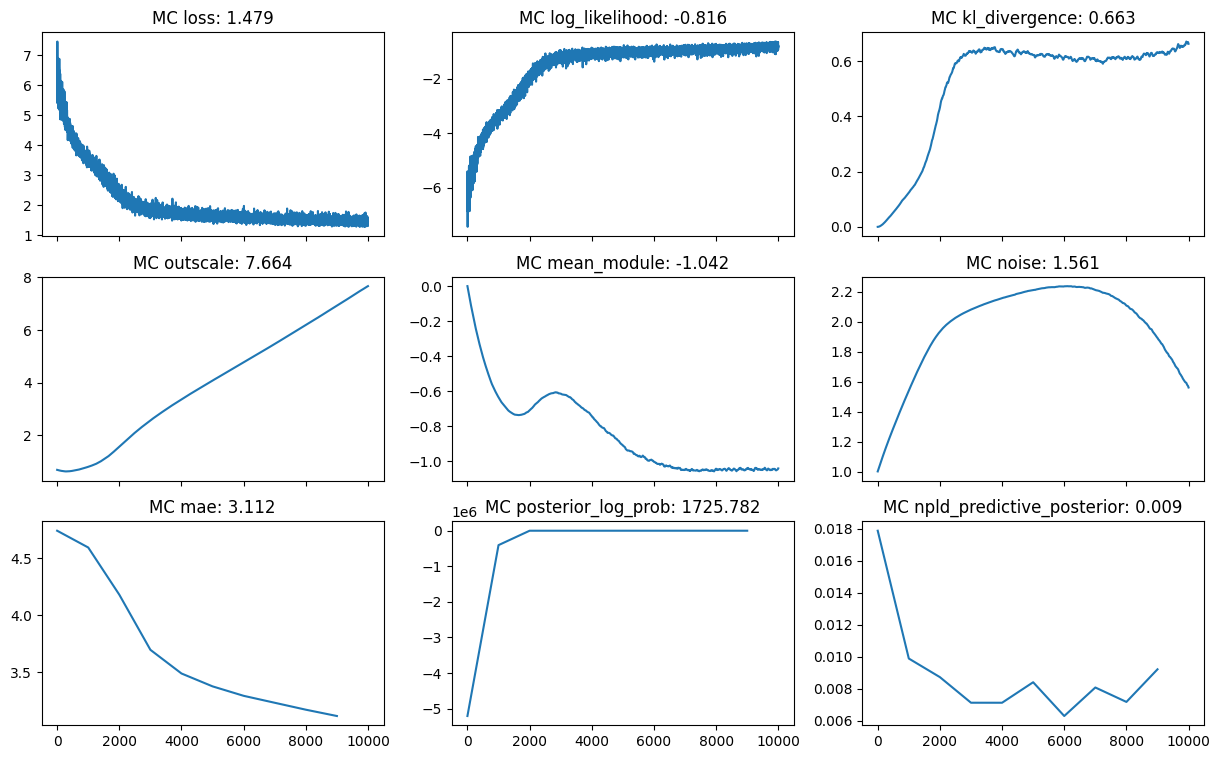

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 10%|█         | 1/10 [02:17<20:33, 137.08s/it]


--Iter: 0 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01715994, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 1
training learner: x_size torch.Size([6]), pool_size torch.Size([14])


  0%|          | 7/10000 [00:00<02:34, 64.79it/s]

loss 6.306520462036133
log_likelihood -6.306519508361816
kl_divergence 7.152557941481064e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999999310821295
noise 1.0006322860717773


 10%|█         | 1007/10000 [00:13<02:05, 71.76it/s]

loss 3.6151371002197266
log_likelihood -3.47049880027771
kl_divergence 0.14463821053504944
log_prior 0.0
outscale 0.851859986782074
mean_module -0.6880634427070618
noise 1.5318559408187866


 20%|██        | 2015/10000 [00:27<01:50, 72.25it/s]

loss 2.776118755340576
log_likelihood -2.3282833099365234
kl_divergence 0.44783538579940796
log_prior 0.0
outscale 1.4773023128509521
mean_module -0.8582432866096497
noise 1.934152603149414


 30%|███       | 3007/10000 [00:40<01:39, 70.60it/s]

loss 2.0644047260284424
log_likelihood -1.4729559421539307
kl_divergence 0.5914487242698669
log_prior 0.0
outscale 2.525395393371582
mean_module -0.8633289933204651
noise 2.1239211559295654


 40%|████      | 4007/10000 [00:53<01:23, 71.76it/s]

loss 2.065309524536133
log_likelihood -1.4476597309112549
kl_divergence 0.6176496744155884
log_prior 0.0
outscale 3.363485336303711
mean_module -1.0839869976043701
noise 2.2159950733184814


 50%|█████     | 5015/10000 [01:07<01:07, 73.44it/s]

loss 1.635327935218811
log_likelihood -1.0264606475830078
kl_divergence 0.6088672876358032
log_prior 0.0
outscale 4.0691328048706055
mean_module -1.3604625463485718
noise 2.2621068954467773


 60%|██████    | 6015/10000 [01:20<00:54, 72.95it/s]

loss 1.7010347843170166
log_likelihood -1.0869930982589722
kl_divergence 0.6140416264533997
log_prior 0.0
outscale 4.733292579650879
mean_module -1.561558485031128
noise 2.2673282623291016


 70%|███████   | 7012/10000 [01:34<00:40, 73.24it/s]

loss 1.6384742259979248
log_likelihood -1.0145304203033447
kl_divergence 0.6239437460899353
log_prior 0.0
outscale 5.406291484832764
mean_module -1.7027788162231445
noise 2.2071714401245117


 80%|████████  | 8012/10000 [01:47<00:27, 73.56it/s]

loss 1.9015281200408936
log_likelihood -1.2644445896148682
kl_divergence 0.6370834708213806
log_prior 0.0
outscale 6.101071834564209
mean_module -1.7930028438568115
noise 2.0384621620178223


 90%|█████████ | 9012/10000 [02:01<00:14, 69.38it/s]

loss 1.626086711883545
log_likelihood -0.9554485082626343
kl_divergence 0.6706382632255554
log_prior 0.0
outscale 6.814408302307129
mean_module -1.8566840887069702
noise 1.7297574281692505


100%|██████████| 10000/10000 [02:14<00:00, 74.37it/s]


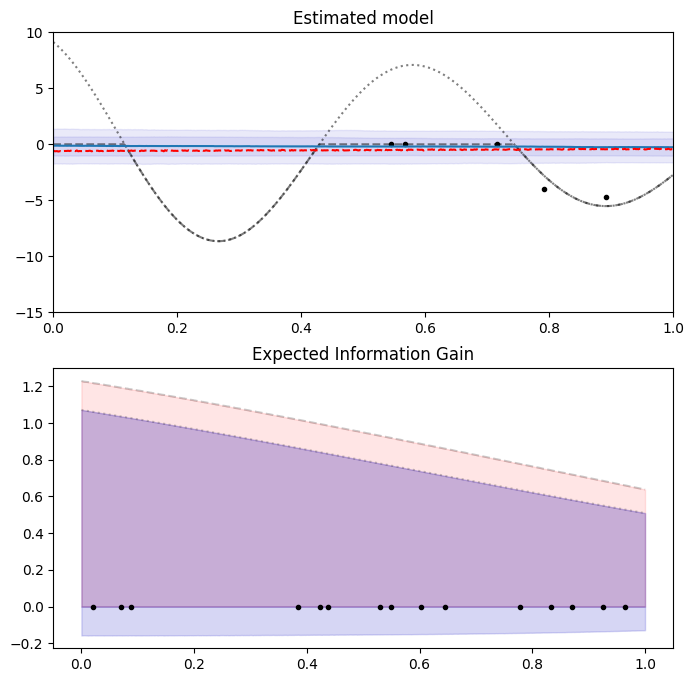

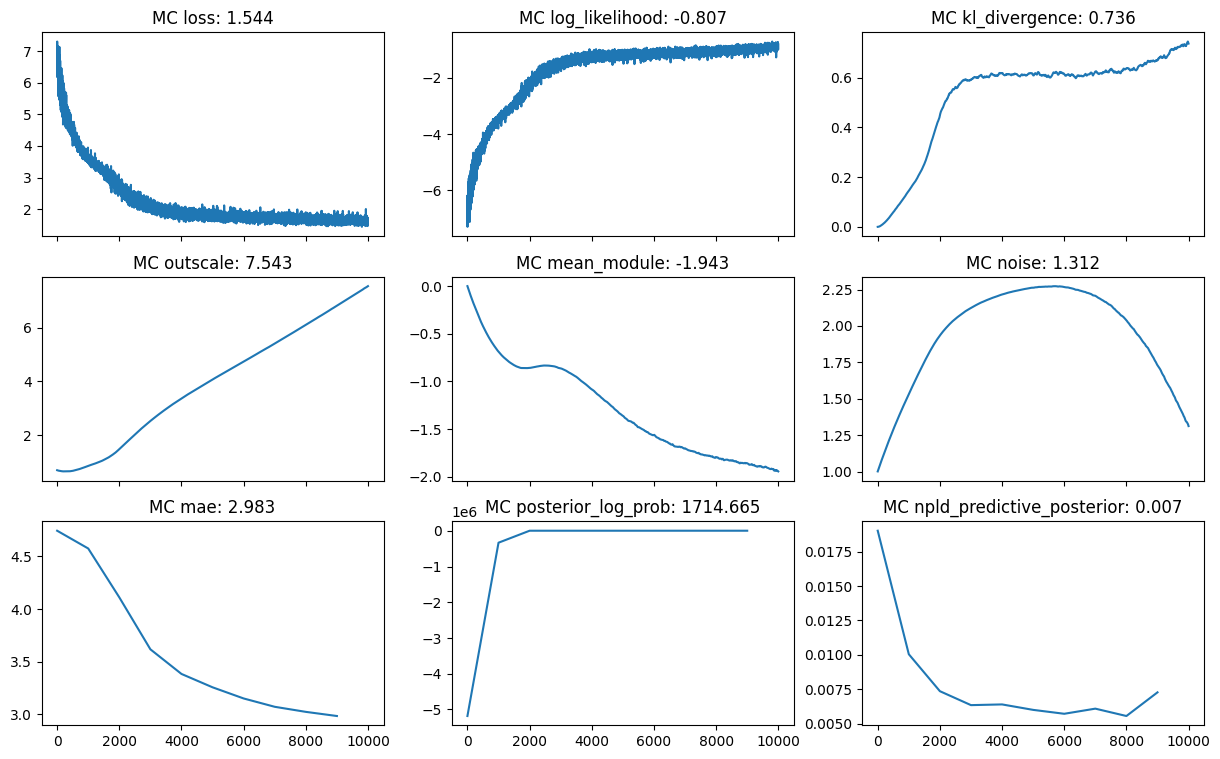

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 20%|██        | 2/10 [04:33<18:15, 136.96s/it]


--Iter: 1 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01708655, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 2
training learner: x_size torch.Size([7]), pool_size torch.Size([13])


  0%|          | 7/10000 [00:00<02:40, 62.26it/s]

loss 5.720766067504883
log_likelihood -5.720766067504883
kl_divergence 2.384185791015625e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0010000000474974513
noise 1.0006322860717773


 10%|█         | 1007/10000 [00:13<02:06, 70.98it/s]

loss 3.3409011363983154
log_likelihood -3.229424476623535
kl_divergence 0.11147671937942505
log_prior 0.0
outscale 0.7026401162147522
mean_module -0.6374977231025696
noise 1.5405575037002563


 20%|██        | 2007/10000 [00:27<01:56, 68.66it/s]

loss 2.30466628074646
log_likelihood -1.863715410232544
kl_divergence 0.440950870513916
log_prior 0.0
outscale 1.3280270099639893
mean_module -0.7628353238105774
noise 1.955790638923645


 30%|███       | 3007/10000 [00:40<01:39, 70.06it/s]

loss 1.7604345083236694
log_likelihood -1.2077175378799438
kl_divergence 0.5527169704437256
log_prior 0.0
outscale 2.380969524383545
mean_module -0.8383800387382507
noise 2.110877752304077


 40%|████      | 4015/10000 [00:54<01:22, 72.68it/s]

loss 1.611755132675171
log_likelihood -1.0524767637252808
kl_divergence 0.5592783689498901
log_prior 0.0
outscale 3.172638416290283
mean_module -1.1056808233261108
noise 2.1822779178619385


 50%|█████     | 5015/10000 [01:07<01:08, 72.93it/s]

loss 1.504813551902771
log_likelihood -0.9391826391220093
kl_divergence 0.5656309127807617
log_prior 0.0
outscale 3.865885019302368
mean_module -1.3829697370529175
noise 2.204850435256958


 60%|██████    | 6007/10000 [01:21<00:55, 71.39it/s]

loss 1.5219385623931885
log_likelihood -0.9601976275444031
kl_divergence 0.5617408752441406
log_prior 0.0
outscale 4.530078411102295
mean_module -1.5852612257003784
noise 2.167278528213501


 70%|███████   | 7015/10000 [01:34<00:40, 72.82it/s]

loss 1.5463886260986328
log_likelihood -0.9693978428840637
kl_divergence 0.5769907236099243
log_prior 0.0
outscale 5.208967685699463
mean_module -1.7191529273986816
noise 2.043875217437744


 80%|████████  | 8013/10000 [01:48<00:27, 71.47it/s]

loss 1.4848339557647705
log_likelihood -0.8857200741767883
kl_divergence 0.599113941192627
log_prior 0.0
outscale 5.907878875732422
mean_module -1.8292409181594849
noise 1.7908517122268677


 90%|█████████ | 9013/10000 [02:01<00:13, 71.39it/s]

loss 1.459540843963623
log_likelihood -0.8150568604469299
kl_divergence 0.6444840431213379
log_prior 0.0
outscale 6.616455078125
mean_module -1.9183611869812012
noise 1.4042104482650757


100%|██████████| 10000/10000 [02:15<00:00, 73.98it/s]


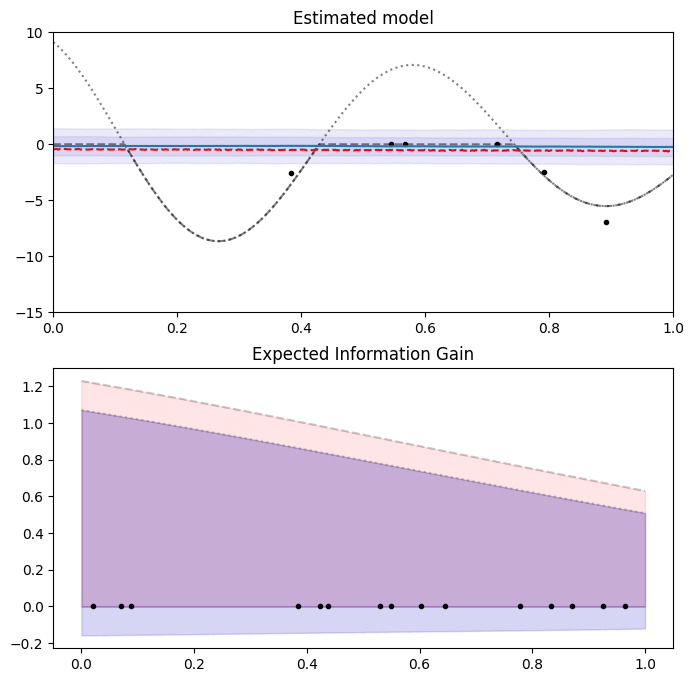

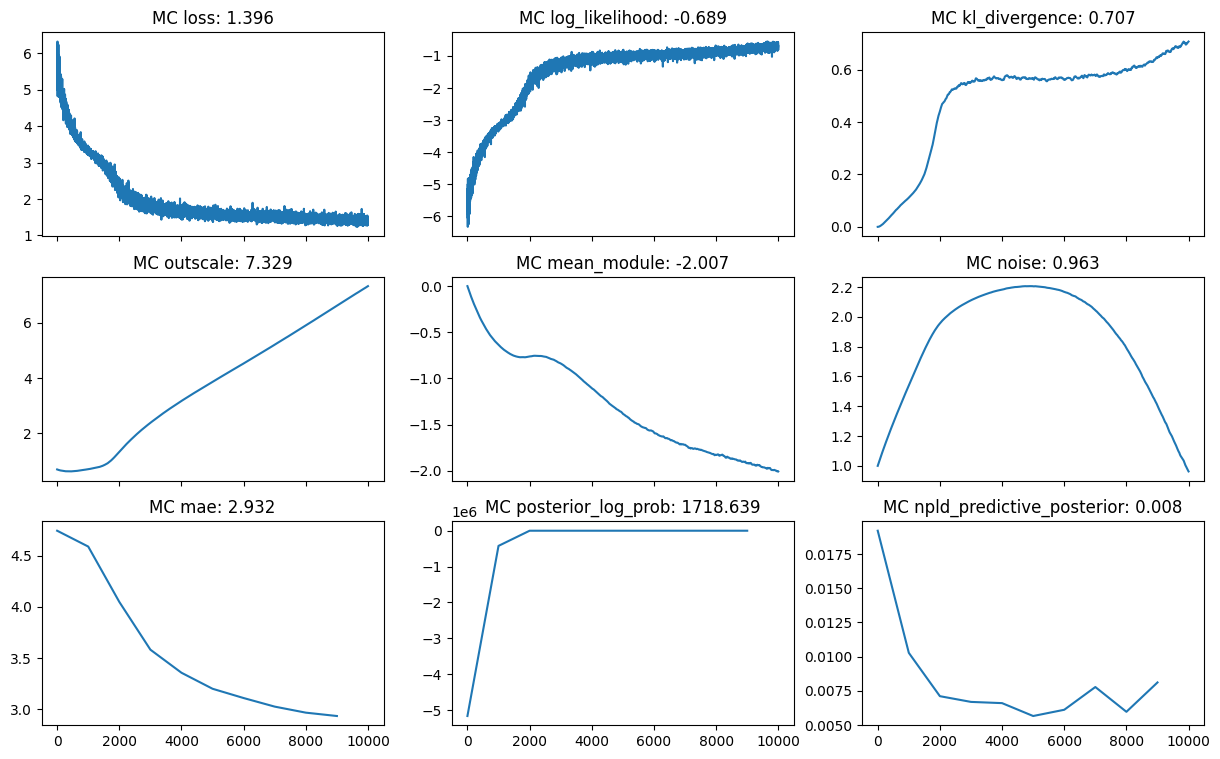

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 30%|███       | 3/10 [06:51<16:00, 137.17s/it]


--Iter: 2 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.0168724, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 3
training learner: x_size torch.Size([8]), pool_size torch.Size([12])


  0%|          | 7/10000 [00:00<02:35, 64.40it/s]

loss 4.834477424621582
log_likelihood -4.834476947784424
kl_divergence 4.238552548940788e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0009999998146668077
noise 1.0006322860717773


 10%|█         | 1007/10000 [00:13<02:03, 72.64it/s]

loss 2.845104932785034
log_likelihood -2.765047311782837
kl_divergence 0.08005767315626144
log_prior 0.0
outscale 0.5855330228805542
mean_module -0.5555165410041809
noise 1.5437533855438232


 20%|██        | 2007/10000 [00:27<01:52, 71.11it/s]

loss 2.121131181716919
log_likelihood -1.8400673866271973
kl_divergence 0.2810637056827545
log_prior 0.0
outscale 1.01692533493042
mean_module -0.6350469589233398
noise 1.9814831018447876


 30%|███       | 3007/10000 [00:40<01:40, 69.79it/s]

loss 1.6838793754577637
log_likelihood -1.241424560546875
kl_divergence 0.4424547553062439
log_prior 0.0
outscale 2.0173234939575195
mean_module -0.6607758402824402
noise 2.16854190826416


 40%|████      | 4007/10000 [00:54<01:26, 69.48it/s]

loss 1.6819379329681396
log_likelihood -1.2098593711853027
kl_divergence 0.4720785319805145
log_prior 0.0
outscale 2.8019216060638428
mean_module -0.8803096413612366
noise 2.2578248977661133


 50%|█████     | 5007/10000 [01:07<01:11, 69.93it/s]

loss 1.5562782287597656
log_likelihood -1.081840991973877
kl_divergence 0.4744371771812439
log_prior 0.0
outscale 3.5027544498443604
mean_module -1.069686770439148
noise 2.289661407470703


 60%|██████    | 6007/10000 [01:21<00:57, 69.40it/s]

loss 1.6456698179244995
log_likelihood -1.1572167873382568
kl_divergence 0.4884530305862427
log_prior 0.0
outscale 4.184459686279297
mean_module -1.2017630338668823
noise 2.2597880363464355


 70%|███████   | 7007/10000 [01:34<00:41, 71.87it/s]

loss 1.5519630908966064
log_likelihood -1.050382137298584
kl_divergence 0.5015810132026672
log_prior 0.0
outscale 4.876208782196045
mean_module -1.287907361984253
noise 2.1314799785614014


 80%|████████  | 8015/10000 [01:48<00:27, 72.59it/s]

loss 1.442840337753296
log_likelihood -0.9260891675949097
kl_divergence 0.5167511701583862
log_prior 0.0
outscale 5.586035251617432
mean_module -1.3541594743728638
noise 1.867791771888733


 90%|█████████ | 9007/10000 [02:01<00:14, 70.89it/s]

loss 1.4092023372650146
log_likelihood -0.8515377044677734
kl_divergence 0.5576645731925964
log_prior 0.0
outscale 6.330134868621826
mean_module -1.4394700527191162
noise 1.5065727233886719


100%|██████████| 10000/10000 [02:15<00:00, 73.96it/s]


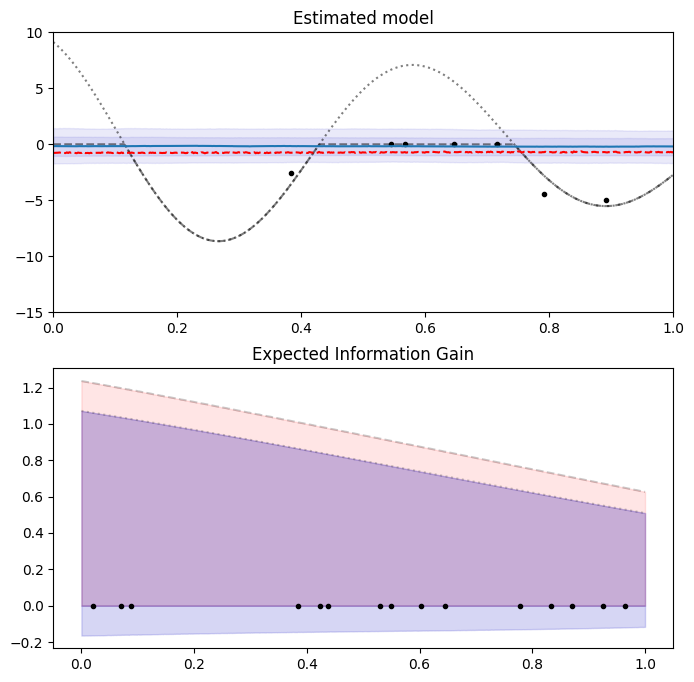

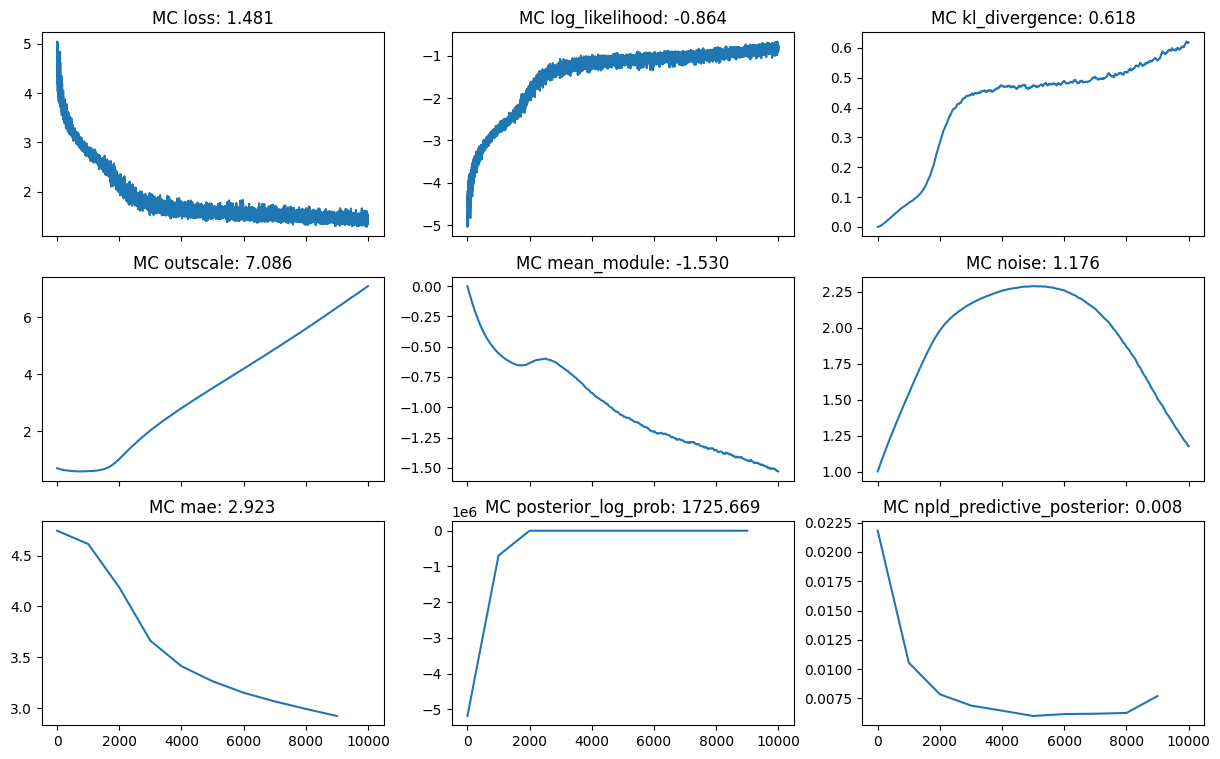

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 40%|████      | 4/10 [09:09<13:44, 137.36s/it]


--Iter: 3 performance:
{'mae': array(4.716313, dtype=float32),
 'npld_posterior': array(10464.254, dtype=float32),
 'npld_predictive_posterior': array(0.01700495, dtype=float32),
 'posterior_log_prob': array(-5232126.5, dtype=float32)}
--- pool updated ---

--Iter: 4
training learner: x_size torch.Size([9]), pool_size torch.Size([11])


  0%|          | 6/10000 [00:00<02:46, 59.94it/s]

loss 5.43601131439209
log_likelihood -5.43601131439209
kl_divergence 1.9073486612342094e-07
log_prior 0.0
outscale 0.6926473379135132
mean_module -0.0010000000474974513
noise 1.0006322860717773


 10%|█         | 1014/10000 [00:13<02:04, 71.99it/s]

loss 3.293902635574341
log_likelihood -3.216040849685669
kl_divergence 0.0778617411851883
log_prior 0.0
outscale 0.6375442147254944
mean_module -0.5684072971343994
noise 1.5555553436279297


 20%|██        | 2014/10000 [00:27<01:51, 71.33it/s]

loss 2.3120815753936768
log_likelihood -1.9735463857650757
kl_divergence 0.3385351300239563
log_prior 0.0
outscale 1.196544885635376
mean_module -0.5825304388999939
noise 2.0172278881073


 21%|██        | 2086/10000 [00:28<01:46, 74.24it/s]

In [ ]:
### training loop

# AL loop
steps = 2
pbar = tqdm.tqdm(range(steps), position=0, leave=True)
results_dict = {}

# data
x_pool = x_pool_init
x = x_init[idx_init]
y_ = oracle(x)

# learner
num_epochs_ = 10000
print_eval_ = 1000
acquisition_fcn = bald_acquisition

for iter_ in pbar:
  print('\n--Iter: %s'%(iter_))
  print("training learner: x_size %s, pool_size %s"%(x.size(), x_pool.size()))

  model = GPModel(inducing_points=x[:,None])
  likelihood = CensoredGaussianLikelihood(low=-100., high=MAX_VALUE)
  loss = gpytorch.mlls.VariationalELBO(likelihood, model, beta=1., combine_terms=False, num_data=y.size(0))

  optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.001)

  model = model.to(device)
  likelihood = likelihood.to(device)

  training_results = train_learner(x[:,None], oracle(x), model, likelihood, loss, optimizer, num_epochs_, print_eval_)
  performance = evaluate_learner(trainig_results['model'], trainig_results['likelihood'], domain[:, None], y_test)

  plot_metrics(training_results['logs'])
  plot_result(trainig_results['model'], trainig_results['likelihood'])

  print("\n--Iter: %s performance:"%(iter_))
  pprint.pprint(performance)

  # query new point
  idx_new_, x_new = acquisition_fcn(x_pool)

  # label the new point and exclude from the pool
  x_pool = update_pool(x_pool, idx_new_)
  x, y = update_labeled_set(x, x_new, oracle)
  print('--- pool updated ---')

  results_dict[iter_] = {
      'model': trainig_results['model'],
      'likelihood': trainig_results['likelihood'],
      'logs': training_results['logs'],
      'performance': performance,
      'querry': [idx_new_, x_new],
    }

results_dict_random = results_dict